# Eindopdracht Tijdreeksen 2122
Ymke van der Waal en Lea van den Heuvel

**De opdracht:**

**Duurzame energie is hot. Maak een voorspellingsmodel dat 1 week vooruit voorspelt wat het energieverbruik door zonnepanelen is. Hanteer hierbij als maatstaf MAPE. Beschrijf de invloed van de weersvariabelen op het energieverbruik door zonnepanelen.**

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import dateparser
from datetime import timedelta
import pmdarima as pm
from statsmodels.graphics.gofplots import qqplot
import datetime

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams['image.cmap']='Paired'
np.random.seed(42)

# 1 Data importeren en eerste bewerkingen

### 1.1 Energie data
Als je de data download gaat het niet verder dan twee jaar terug, dus moeten we een eerder gedownloade dataset samenvoegen met een dataset van later.

Variabelen:
- Stroom 1 (in kWh): Electricitreitsverbruik, gemeten bij meter 1
- Stroom 2 (in kWh): Electricitreitsverbruik, gemeten bij meter 2
- Teruglevering 1 (in kWh): Terug-geleverde electriciteit, gewonnen met zonnepanelen groep 1
- Teruglevering 2 (in kWh): Terug-geleverde electriciteit, gewonnen met zonnepanelen groep 2
- Gas 1 (in m3): Gasverbruik
- Opmerkingen

#### 1.1.1 Eerste dataset

In [181]:
# Eerste dataset
ts1 = pd.read_csv('mijn-meterstanden.csv')
ts1.head(3)

,Meetdatum,Stroom 1 (kWh),Stroom 2 (kWh),Teruglevering 1 (kWh),Teruglevering 2 (kWh),Gas 1 (m3),Opmerkingen
0,25 mei 2021,9.172,8.999,823.0,2.009,6.931,Smartmeter
1,24 mei 2021,9.166,8.999,816.0,2.009,6.928,Smartmeter
2,23 mei 2021,9.153,8.999,807.0,2.009,6.927,Smartmeter


In [182]:
# Zet datum om
ts1['Meetdatum'] = ts1.Meetdatum.apply(lambda x: dateparser.parse(x))
ts1.head(3)

C:\Users\Lea\Programs\anaconda3\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


,Meetdatum,Stroom 1 (kWh),Stroom 2 (kWh),Teruglevering 1 (kWh),Teruglevering 2 (kWh),Gas 1 (m3),Opmerkingen
0,2021-05-25,9.172,8.999,823.0,2.009,6.931,Smartmeter
1,2021-05-24,9.166,8.999,816.0,2.009,6.928,Smartmeter
2,2021-05-23,9.153,8.999,807.0,2.009,6.927,Smartmeter


#### 1.1.2 Tweede dataset

In [183]:
# Tweede dataset
ts2 = pd.read_csv('mijn-meterstanden_3.csv')
ts2.head(3)

,Meetdatum,Stroom 1 (kWh),Stroom 2 (kWh),Teruglevering 1 (kWh),Teruglevering 2 (kWh),Gas 1 (m3),Opmerkingen
0,31 mei 2021,9.195,9.019,865.0,2.067,6.936,Smartmeter
1,30 mei 2021,9.181,9.019,843.0,2.067,6.935,Smartmeter
2,29 mei 2021,9.177,9.019,823.0,2.067,6.934,Smartmeter


In [184]:
# Zet datum om
ts2['Meetdatum'] = ts2.Meetdatum.apply(lambda x: dateparser.parse(x))
ts2.head(3)

C:\Users\Lea\Programs\anaconda3\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


,Meetdatum,Stroom 1 (kWh),Stroom 2 (kWh),Teruglevering 1 (kWh),Teruglevering 2 (kWh),Gas 1 (m3),Opmerkingen
0,2021-05-31,9.195,9.019,865.0,2.067,6.936,Smartmeter
1,2021-05-30,9.181,9.019,843.0,2.067,6.935,Smartmeter
2,2021-05-29,9.177,9.019,823.0,2.067,6.934,Smartmeter


#### 1.1.3 Samenvoegen

In [185]:
# Voeg de twee datasets samen
ts = ts2[ts2.Meetdatum > ts1.Meetdatum.max()] # Set met data die extra worden toegevoegd aan ts1
ts = pd.concat([ts, ts1]) # Voeg de twee sets samen
ts.head(10)

,Meetdatum,Stroom 1 (kWh),Stroom 2 (kWh),Teruglevering 1 (kWh),Teruglevering 2 (kWh),Gas 1 (m3),Opmerkingen
0,2021-05-31,9.195,9.019,865.0,2.067,6.936,Smartmeter
1,2021-05-30,9.181,9.019,843.0,2.067,6.935,Smartmeter
2,2021-05-29,9.177,9.019,823.0,2.067,6.934,Smartmeter
3,2021-05-28,9.176,9.017,823.0,2.042,6.934,Smartmeter
4,2021-05-27,9.175,9.014,823.0,2.033,6.932,Smartmeter
5,2021-05-26,9.174,9.004,823.0,2.022,6.931,Smartmeter
0,2021-05-25,9.172,8.999,823.0,2.009,6.931,Smartmeter
1,2021-05-24,9.166,8.999,816.0,2.009,6.928,Smartmeter
2,2021-05-23,9.153,8.999,807.0,2.009,6.927,Smartmeter
3,2021-05-22,9.146,8.999,799.0,2.009,6.925,Smartmeter


#### 1.1.4 Data inspecteren

In [186]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763 entries, 0 to 756
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Meetdatum              763 non-null    datetime64[ns]
 1   Stroom 1 (kWh)         763 non-null    float64       
 2   Stroom 2 (kWh)         763 non-null    float64       
 3   Teruglevering 1 (kWh)  342 non-null    float64       
 4   Teruglevering 2 (kWh)  344 non-null    float64       
 5   Gas 1 (m3)             763 non-null    float64       
 6   Opmerkingen            763 non-null    object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 47.7+ KB


In [187]:
def check_dates(x):
    '''Functie om te checken of datum vóór en na in ts staan, zodat het gefilterd kan worden en het een timeseries is
    Returned boolean, True wanneer datum vóór en na gecheckte datum in de dataframe staan'''
    d = timedelta(days=1)
    # Check of dag ervoor en dag erna in ts staan, dan is het ts
    if ((x-d) in ts.Meetdatum.values) and ((x+d) in ts.Meetdatum.values):
        return True
    else: return False

In [188]:
# Nieuwe kolom met of de datum ervoor en erna in ts staan
ts['check_dates'] = ts['Meetdatum'].apply(lambda x: check_dates(x))
ts.head(3)

,Meetdatum,Stroom 1 (kWh),Stroom 2 (kWh),Teruglevering 1 (kWh),Teruglevering 2 (kWh),Gas 1 (m3),Opmerkingen,check_dates
0,2021-05-31,9.195,9.019,865.0,2.067,6.936,Smartmeter,False
1,2021-05-30,9.181,9.019,843.0,2.067,6.935,Smartmeter,True
2,2021-05-29,9.177,9.019,823.0,2.067,6.934,Smartmeter,True


In [189]:
ts = ts[ts['check_dates']] # Behoud alleen rijen waarbij de dag ervoor en erna ook in de dataset staan
ts.drop(columns = ['Opmerkingen', 'check_dates'], inplace = True) # Drop onnodige kolommen
ts.set_index('Meetdatum', inplace =True) # Set index
ts.head(3)

,Stroom 1 (kWh),Stroom 2 (kWh),Teruglevering 1 (kWh),Teruglevering 2 (kWh),Gas 1 (m3)
Meetdatum,,,,,
2021-05-30,9.181,9.019,843.0,2.067,6.935
2021-05-29,9.177,9.019,823.0,2.067,6.934
2021-05-28,9.176,9.017,823.0,2.042,6.934


In [190]:
# Door het excel format zijn alle getallen groter dan 1000 omgezet naar floats
# Het zijn geen floats maar integers, dus alle getallen boven de 1000 moeten worden vermenigvuldigd met 1000
cols = [ 'Stroom 1 (kWh)', 'Stroom 2 (kWh)', 'Teruglevering 1 (kWh)', 'Teruglevering 2 (kWh)', 'Gas 1 (m3)']

for col in cols:
    ts[col] = ts[col].apply(lambda x: (x*1000) if (x < 10) else x)
    
ts.head(3)

,Stroom 1 (kWh),Stroom 2 (kWh),Teruglevering 1 (kWh),Teruglevering 2 (kWh),Gas 1 (m3)
Meetdatum,,,,,
2021-05-30,9181.0,9019.0,843.0,2067.0,6935.0
2021-05-29,9177.0,9019.0,823.0,2067.0,6934.0
2021-05-28,9176.0,9017.0,823.0,2042.0,6934.0


In [191]:
# Nieuwe kolommen
# Stroom in kWh
ts['stroom'] = ts['Stroom 1 (kWh)'] + ts['Stroom 2 (kWh)']
# Teruglevering in kWh
ts['teruglevering'] = ts['Teruglevering 1 (kWh)'] + ts['Teruglevering 2 (kWh)']
# Gas in m3
ts.rename(columns = {'Gas 1 (m3)': 'gas'}, inplace = True)
# Filter nodige kolommen
ts = ts[['gas', 'stroom', 'teruglevering']].copy()
ts.head(3)

,gas,stroom,teruglevering
Meetdatum,,,
2021-05-30,6935.0,18200.0,2910.0
2021-05-29,6934.0,18196.0,2890.0
2021-05-28,6934.0,18193.0,2865.0


In [192]:
ts.describe()

,gas,stroom,teruglevering
count,735.000000,735.000000,338.000000
mean,5354.122449,14913.485714,1578.597633
std,846.942378,2121.267077,641.287872
min,4154.000000,11088.000000,0.000000
25%,4527.000000,12998.000000,1329.250000
50%,5494.000000,15372.000000,1641.000000
75%,5775.500000,16616.500000,1901.250000
max,6935.000000,18200.000000,2910.000000


In [193]:
# Missende waarden
ts.isna().sum()

gas                0
stroom             0
teruglevering    397
dtype: int64

In [194]:
ts[ts['teruglevering'].isnull()]
# Er zijn missende waarden omdat er toen nog geen zonnepanelen (=teruglevering) was

,gas,stroom,teruglevering
Meetdatum,,,
2020-06-27,5508.0,15666.0,NaN
2020-06-26,5508.0,15664.0,NaN
2020-06-25,5507.0,15661.0,NaN
2020-06-24,5507.0,15644.0,NaN
2020-06-23,5507.0,15638.0,NaN
...,...,...,...
2019-05-31,4156.0,11139.0,NaN
2019-05-30,4156.0,11119.0,NaN
2019-05-29,4155.0,11113.0,NaN


In [195]:
# Duplicates bekijken
ts[ts.duplicated()]

,gas,stroom,teruglevering
Meetdatum,,,


In [196]:
# Opslaan als csv
# ts.to_csv('energieverbruik_v2.csv')

### 1.2 Weer data 

De data:

- Datum
- Etmaalgemiddelde temperatuur in 0.1 graden Celcius
- Zonneschijnduur in 0.1 uur
- Duur van neerslag in 0.1 uur
- Etmaalsom van de neerslag in 0.1 mm

In [197]:
ts_weer = pd.read_csv('Weer_data.csv')
ts_weer.head(3)

,YYYYMMDD,TG,SQ,DR,RH
0,1991-08-13,147,8,0,-1
1,1991-08-14,162,91,0,0
2,1991-08-15,181,94,0,0


In [198]:
ts_weer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10774 entries, 0 to 10773
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   YYYYMMDD  10774 non-null  object
 1   TG        10774 non-null  int64 
 2   SQ        10774 non-null  int64 
 3   DR        10774 non-null  int64 
 4   RH        10774 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 421.0+ KB


In [199]:
ts_weer.columns

Index(['YYYYMMDD', 'TG', 'SQ', 'DR', 'RH'], dtype='object')

In [200]:
# Rename columns
weer_colnames = {'YYYYMMDD' : 'Date', 'TG' : 'temp', 'SQ' : 'zonneschijn', 
                 'DR' : 'duur_neerslag', 'RH' : 'som_neerslag'}
ts_weer.rename(columns = weer_colnames, inplace = True)
# Date als datetime
ts_weer['Date'] = pd.to_datetime(ts_weer['Date'], format = '%Y-%m-%d')
#Set date als index
ts_weer.set_index('Date', inplace = True)
ts_weer.head(3)

,temp,zonneschijn,duur_neerslag,som_neerslag
Date,,,,
1991-08-13,147,8,0,-1
1991-08-14,162,91,0,0
1991-08-15,181,94,0,0


### 1.3 Datasets mergen

In de datasets die we gaan gebruiken stata dus:

- Gasverbruik (in m3)
- Stroomverbruik (in kWh)
- **Teruglevering stroom (in kWh) is Y**
- Etmaalgemiddelde temperatuur (in 0.1 graden Celsius) 
- Zonneschijnduur (in 0.1 uur)
- Duur van de neerslag (in 0.1 uur) 
- Etmaalsom van de neerslag (in 0.1 mm) 

In [201]:
ts = ts.merge(ts_weer, 
              left_index = True, right_index = True,
              how = 'inner') # Alleen data mergen die in beide sets voorkomen
ts.head(3)

,gas,stroom,teruglevering,temp,zonneschijn,duur_neerslag,som_neerslag
2021-05-30,6935.0,18200.0,2910.0,142,147,0,0
2021-05-29,6934.0,18196.0,2890.0,116,73,0,0
2021-05-28,6934.0,18193.0,2865.0,121,124,0,0


## 2 Visualisaties

In [202]:
# Kolommen verdelen
cols_e = ['gas', 'stroom', 'teruglevering']
cols_w = ['temp', 'zonneschijn', 'duur_neerslag', 'som_neerslag']

### 2.1 Energieverbruik

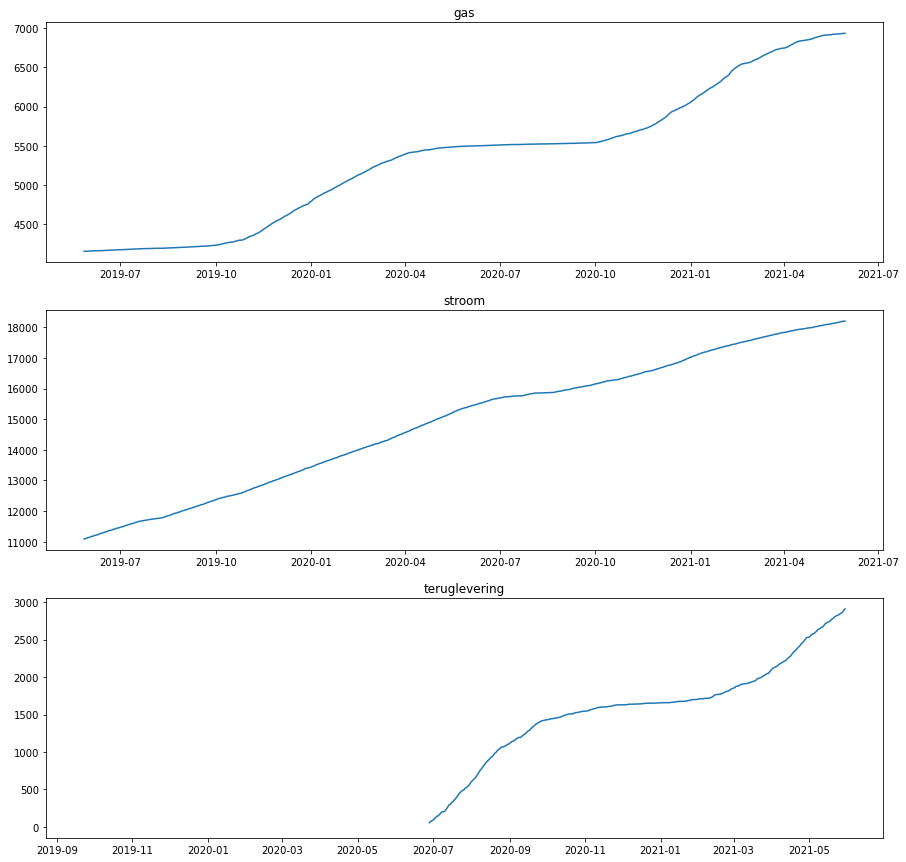

In [203]:
fig, ax = plt.subplots(3,1, figsize = (15,15))

for col in cols_e:
    i = cols_e.index(col)
    ax[i].plot(ts[col])
    ax[i].set_title(col)
    
plt.show()

In [204]:
# Meter is cumulatief dus differentieren om gebruik per dag te krijgen
# Absolute waardes pakken
ts[cols_e] = np.abs(ts[cols_e].diff())
ts.head()

,gas,stroom,teruglevering,temp,zonneschijn,duur_neerslag,som_neerslag
2021-05-30,NaN,NaN,NaN,142,147,0,0
2021-05-29,1.0,4.0,20.0,116,73,0,0
2021-05-28,0.0,3.0,25.0,121,124,0,0
2021-05-27,2.0,4.0,9.0,109,34,84,75
2021-05-26,1.0,11.0,11.0,109,52,59,61


<Figure size 1080x576 with 0 Axes>

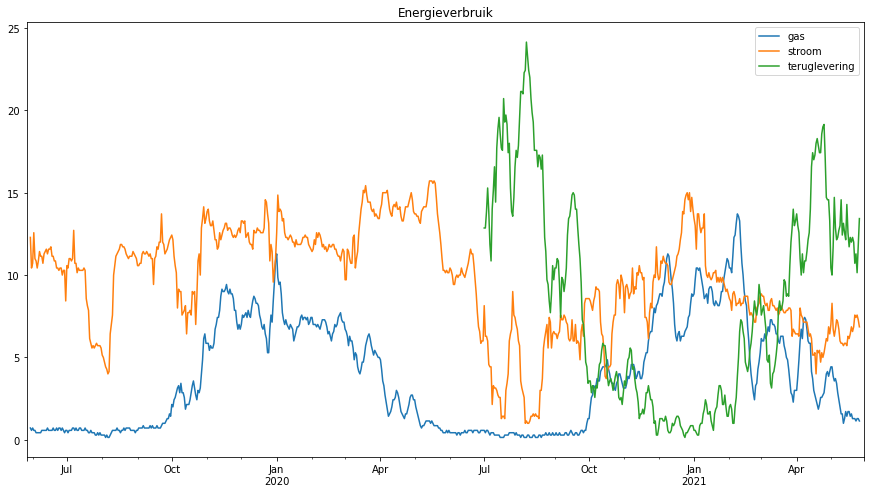

In [205]:
plt.set_cmap('Paired')

ts_rolling = ts[cols_e].rolling(window = 7, center = True).mean()
ts_rolling.plot()
plt.title('Energieverbruik')
plt.legend()
plt.show()

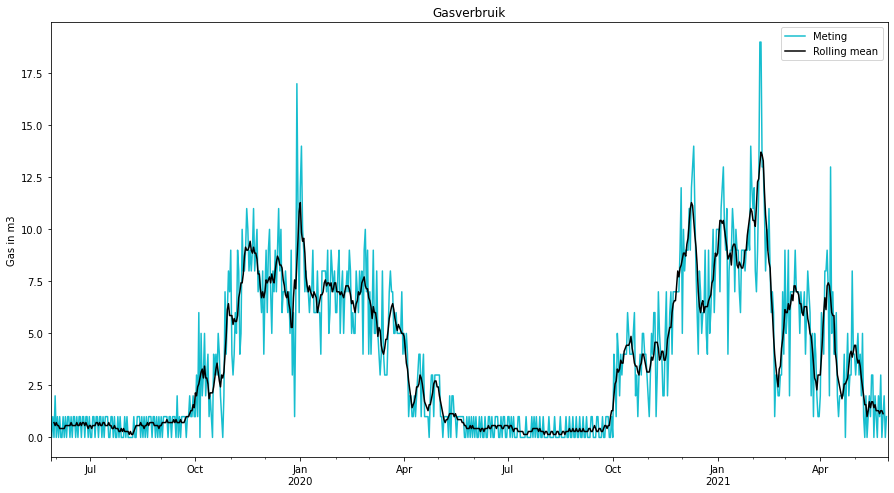

In [206]:
ts['gas'].plot(color = 'tab:cyan', label = 'Meting')

#ts_mean = ts['gas'].rolling(window = 7, center = True).mean()
ts_rolling['gas'].plot(color = "k", label = "Rolling mean")

plt.title('Gasverbruik')
plt.ylabel('Gas in m3')
plt.legend()
plt.show()

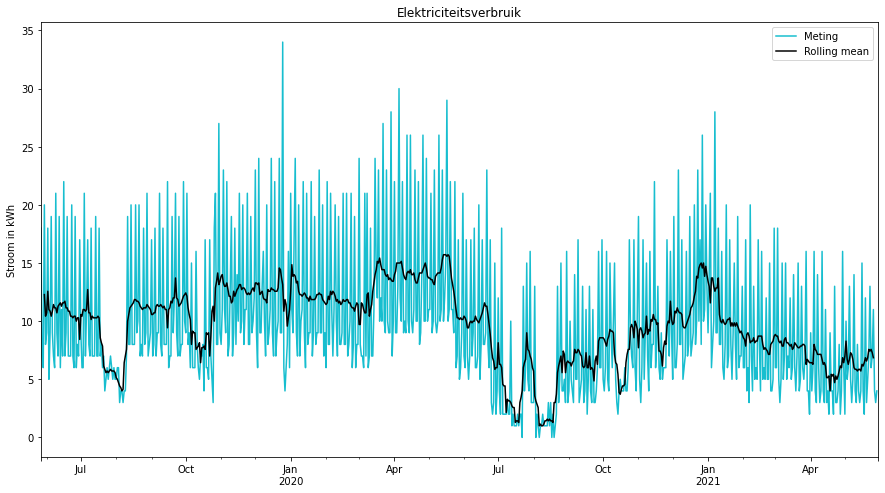

In [207]:
ts['stroom'].plot(color = 'tab:cyan', label = 'Meting')

#ts_mean = ts['stroom'].rolling(window = 7, center = True).mean()
ts_rolling['stroom'].plot(color = "k", label = "Rolling mean")

plt.title('Elektriciteitsverbruik')
plt.ylabel('Stroom in kWh')
plt.legend()
plt.show()

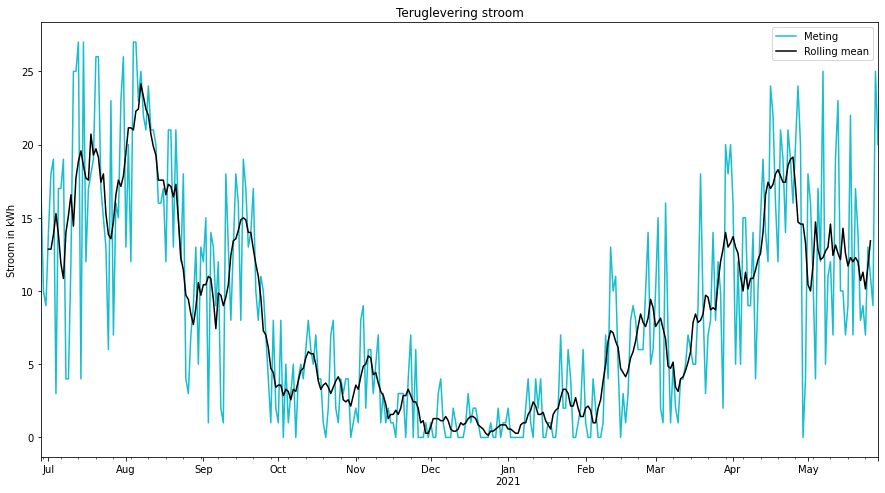

In [208]:
ts['teruglevering'].dropna().plot(color = 'tab:cyan', label = 'Meting')

# ts_mean = ts['teruglevering'].dropna().rolling(window = 7, center = True).mean()
ts_rolling['teruglevering'].dropna().plot(color = "k", label = "Rolling mean")

plt.title('Teruglevering stroom')
plt.ylabel('Stroom in kWh')
plt.legend()
plt.show()

#### 2.1.1 Verdeling van de data

In [209]:
def season(x):
    '''Input is de maand, returned in welk seizoen de maand is'''
    
    if x == 12 or x <= 2:
        return "Winter"
    elif x >= 8:
        return "Autumn"
    elif x >= 6:
        return "Summer"
    else: return "Spring"

In [210]:
# Nieuwe kolom voor dag vd week
ts['day_of_week'] = ts.index.dayofweek
ts['day_of_week_name'] = ts.index.day_name()
# kolom met dag vd maand
ts['day_of_month'] = ts.index.day
# kolom met maand
ts['month'] = ts.index.month 
ts['month_name'] = ts.index.month_name()
 # kolom met seizoen
ts['season'] = ts['month'].apply(lambda x: season(x))
ts['season'] = ts['season'].astype('category')
ts.head(3)

,gas,stroom,teruglevering,temp,zonneschijn,duur_neerslag,som_neerslag,day_of_week,day_of_week_name,day_of_month,month,month_name,season
2021-05-30,NaN,NaN,NaN,142,147,0,0,6,Sunday,30,5,May,Spring
2021-05-29,1.0,4.0,20.0,116,73,0,0,5,Saturday,29,5,May,Spring
2021-05-28,0.0,3.0,25.0,121,124,0,0,4,Friday,28,5,May,Spring


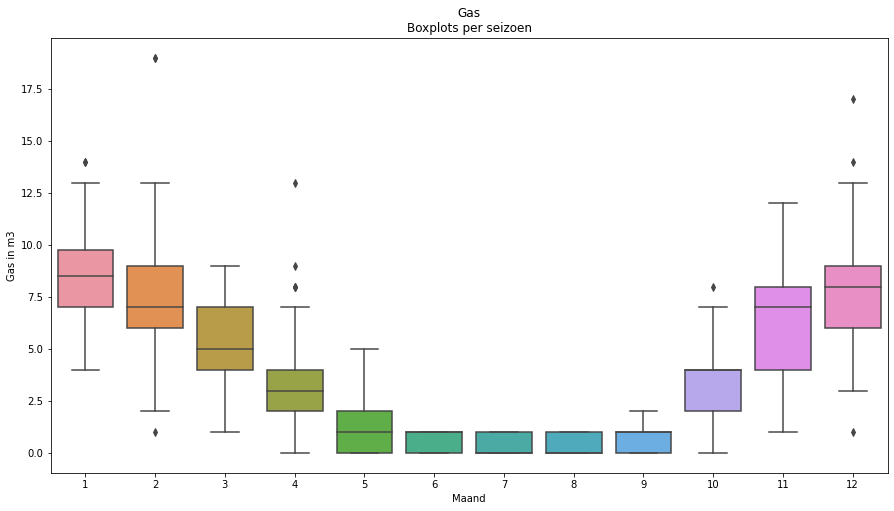

In [211]:
sns.boxplot(data = ts, y = 'gas', x = 'month')
plt.title('Gas\nBoxplots per seizoen')
plt.xlabel('Maand')
plt.ylabel('Gas in m3')
plt.show()

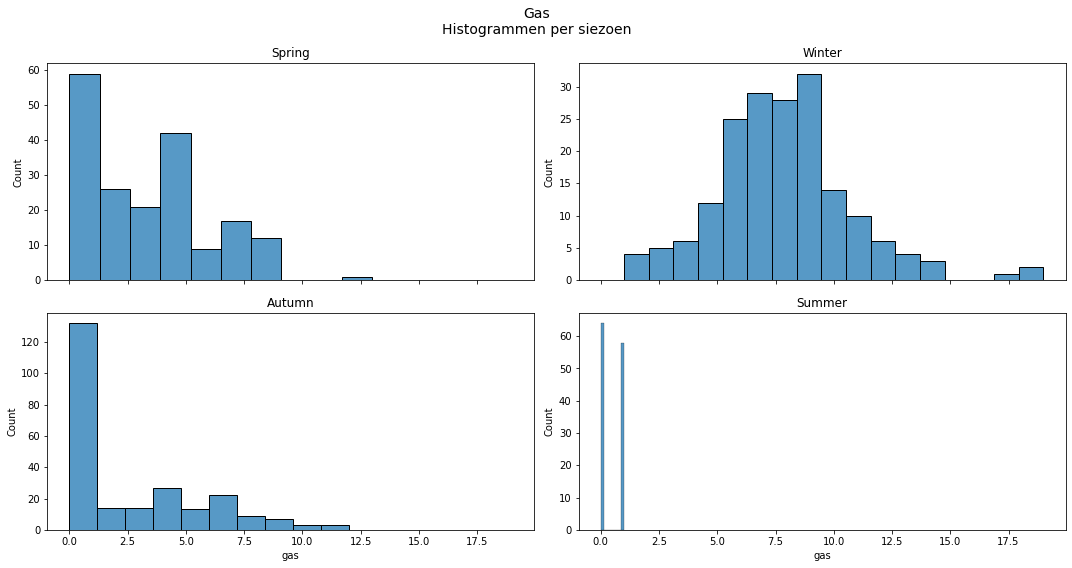

In [212]:
fig, ax = plt.subplots(2,2, sharex = True)
dict_plots = {ax[0][0]: ts.season.unique()[0], # Dict met plot en bijbehorende seizoen
              ax[0][1]: ts.season.unique()[1],
              ax[1][0]: ts.season.unique()[2],
              ax[1][1]: ts.season.unique()[3]}

for i in dict_plots:
    sns.histplot(data = ts[ts['season']==dict_plots[i]], 
                 x = 'gas',
                 ax = i)
    i.set_title(dict_plots[i])

plt.suptitle('Gas\nHistogrammen per siezoen', size = 14)
plt.tight_layout()
plt.show()

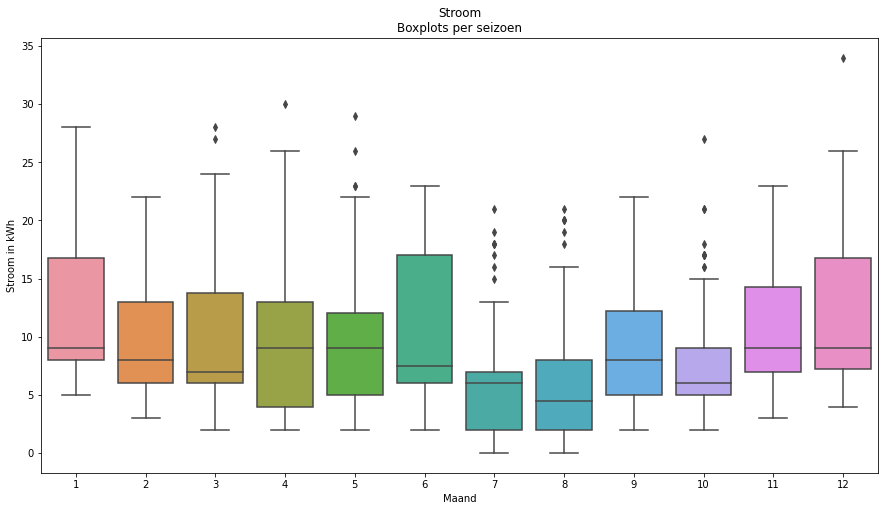

In [213]:
sns.boxplot(data = ts, y = 'stroom', x = 'month')
plt.title('Stroom\nBoxplots per seizoen')
plt.xlabel('Maand')
plt.ylabel('Stroom in kWh')
plt.show()

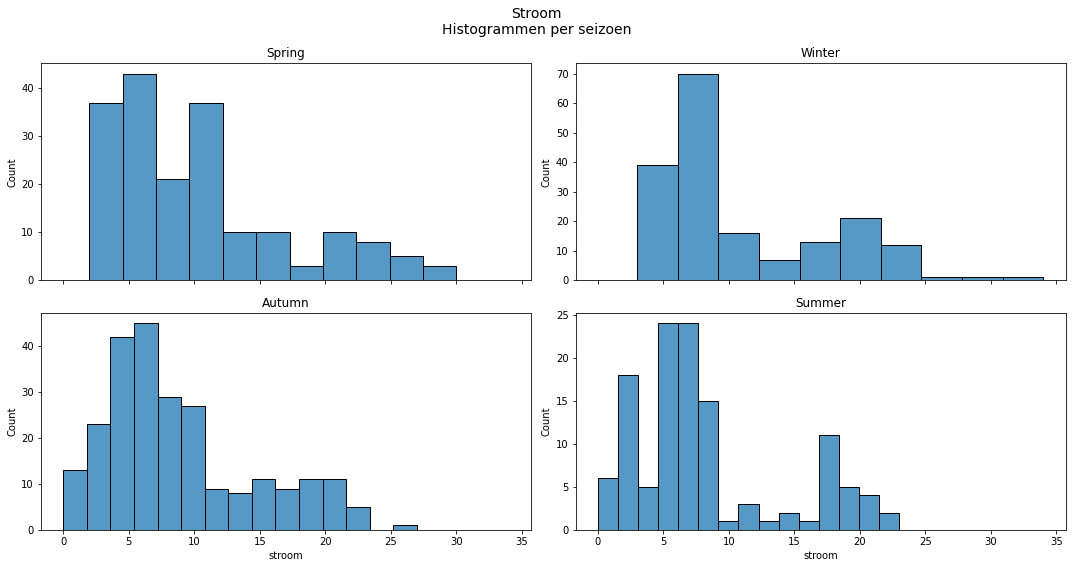

In [214]:
fig, ax = plt.subplots(2,2, sharex = True)
dict_plots = {ax[0][0]: ts.season.unique()[0], # Dict met plot en bijbehorende seizoen
              ax[0][1]: ts.season.unique()[1],
              ax[1][0]: ts.season.unique()[2],
              ax[1][1]: ts.season.unique()[3]}

for i in dict_plots:
    sns.histplot(data = ts[ts['season']==dict_plots[i]], 
                 x = 'stroom',
                 ax = i)
    i.set_title(dict_plots[i])

plt.suptitle('Stroom\nHistogrammen per seizoen', size = 14)
plt.tight_layout()
plt.show()

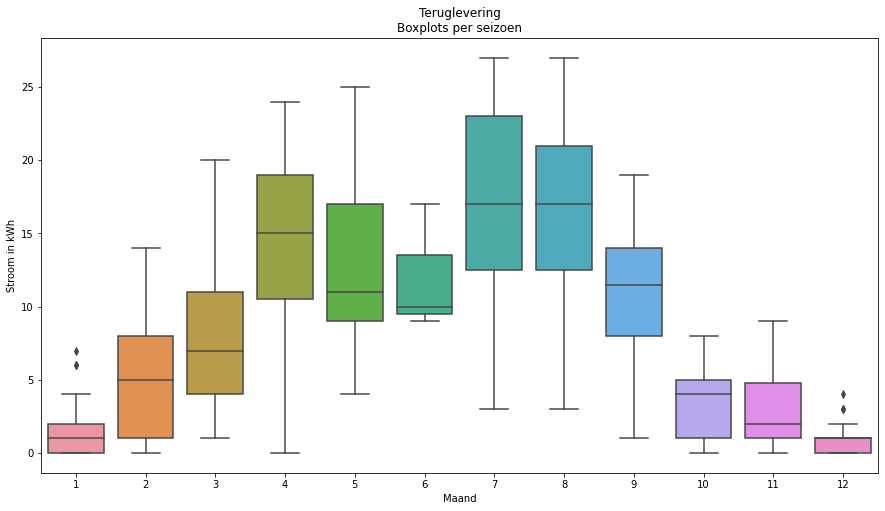

In [215]:
sns.boxplot(data = ts, y = 'teruglevering', x = 'month')
plt.title('Teruglevering\nBoxplots per seizoen')
plt.xlabel('Maand')
plt.ylabel('Stroom in kWh')
plt.show()

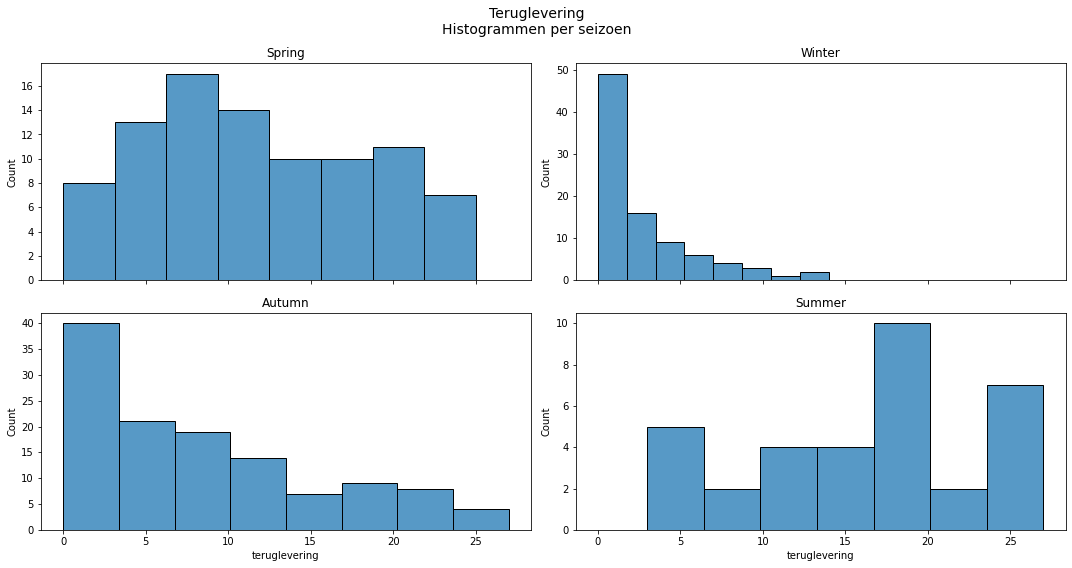

In [216]:
fig, ax = plt.subplots(2,2, sharex = True)
dict_plots = {ax[0][0]: ts.season.unique()[0], # Dict met plot en bijbehorende seizoen
              ax[0][1]: ts.season.unique()[1],
              ax[1][0]: ts.season.unique()[2],
              ax[1][1]: ts.season.unique()[3]}

for i in dict_plots:
    sns.histplot(data = ts[ts['season']==dict_plots[i]], 
                 x = 'teruglevering',
                 ax = i)
    i.set_title(dict_plots[i])

plt.suptitle('Teruglevering\nHistogrammen per seizoen', size = 14)
plt.tight_layout()
plt.show()

#### 2.1.2 Gemiddelden

In [217]:
# Labels voor legenda
legend_labels_e = ['Gasverbruik (m3)', 'Stroomverbruik (kWh)', 'Teruglevering stroom (kWh)']

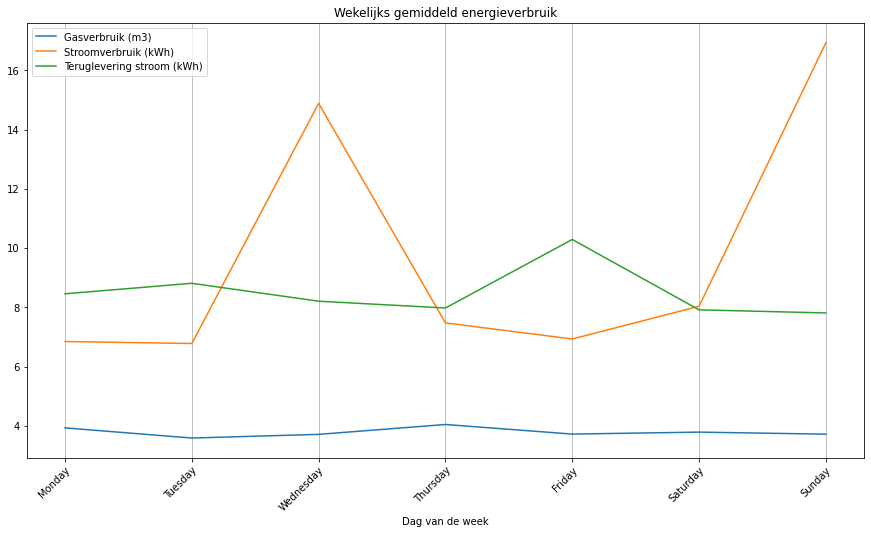

In [218]:
ts_grouped_gas = ts.groupby(['day_of_week', 'day_of_week_name'])[cols_e].mean().reset_index().set_index('day_of_week', drop= True)
ax = ts_grouped_gas.plot()

plt.title('Wekelijks gemiddeld energieverbruik')
plt.xlabel('Dag van de week')
plt.xticks(np.arange(0, 7),
           ts_grouped_gas['day_of_week_name'], 
           rotation = 45,
           ha = 'right', rotation_mode='anchor')

plt.grid(axis = 'x')
ax.legend(legend_labels_e)
plt.show()

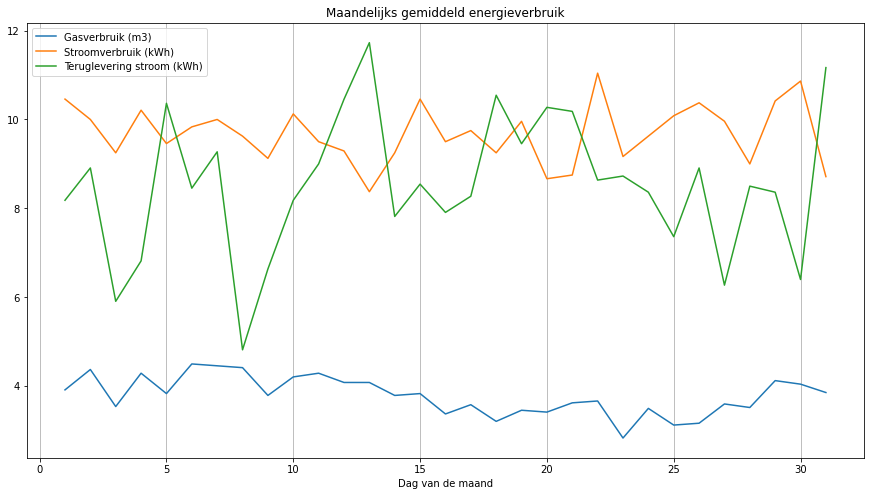

In [219]:
ts_grouped_gas = ts.groupby('day_of_month')[cols_e].mean()
ax = ts_grouped_gas.plot()
plt.title('Maandelijks gemiddeld energieverbruik')
plt.xlabel('Dag van de maand')
plt.grid(axis = 'x')
ax.legend(legend_labels_e)
plt.show()

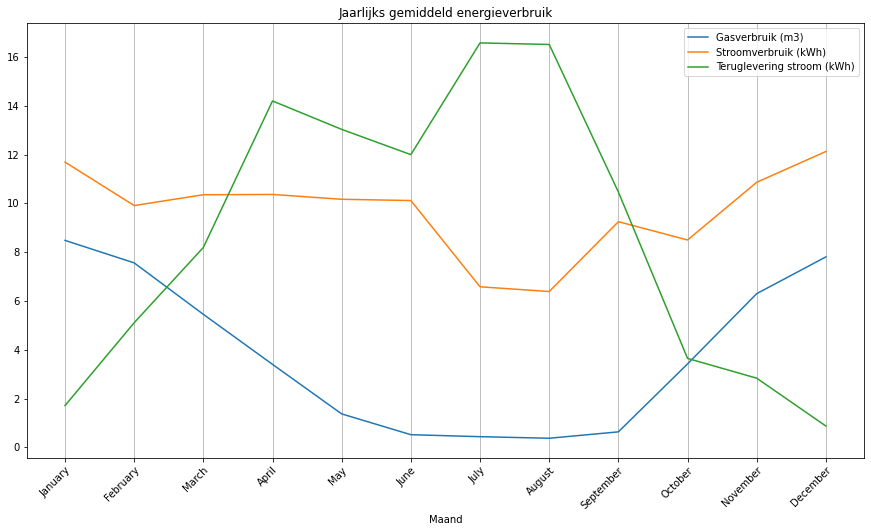

In [220]:
ts_grouped_gas = ts.groupby(['month', 'month_name'])[cols_e].mean().reset_index().set_index('month', drop= True)
ax = ts_grouped_gas.plot()
plt.title('Jaarlijks gemiddeld energieverbruik')
plt.xticks(np.arange(1, 13),
           ts_grouped_gas['month_name'], 
           rotation = 45,
           ha = 'right', rotation_mode='anchor')

plt.xlabel('Maand')
plt.grid(axis = 'x')
ax.legend(legend_labels_e)
plt.show()

Teruglevering heeft een duidelijk jaarlijks seizoenspatroon. ARIMA kan één seizoenspatroon aan, dus er worden geen fourier terms toegevoegd.

### 2.2 Weer data

In [221]:
# Dataset met moving average voor weer data
ts_rolling_w = ts[cols_w].rolling(window = 7, center = True).mean()
ts_rolling_w.head(10)

,temp,zonneschijn,duur_neerslag,som_neerslag
2021-05-30,NaN,NaN,NaN,NaN
2021-05-29,NaN,NaN,NaN,NaN
2021-05-28,NaN,NaN,NaN,NaN
2021-05-27,116.857143,68.714286,37.571429,35.285714
2021-05-26,112.142857,52.571429,38.857143,36.142857
2021-05-25,110.428571,43.428571,46.857143,43.142857
2021-05-24,111.428571,36.714286,49.285714,46.000000
2021-05-23,113.142857,39.142857,38.000000,35.571429
2021-05-22,111.857143,35.285714,31.857143,28.857143
2021-05-21,112.142857,42.428571,31.000000,32.142857


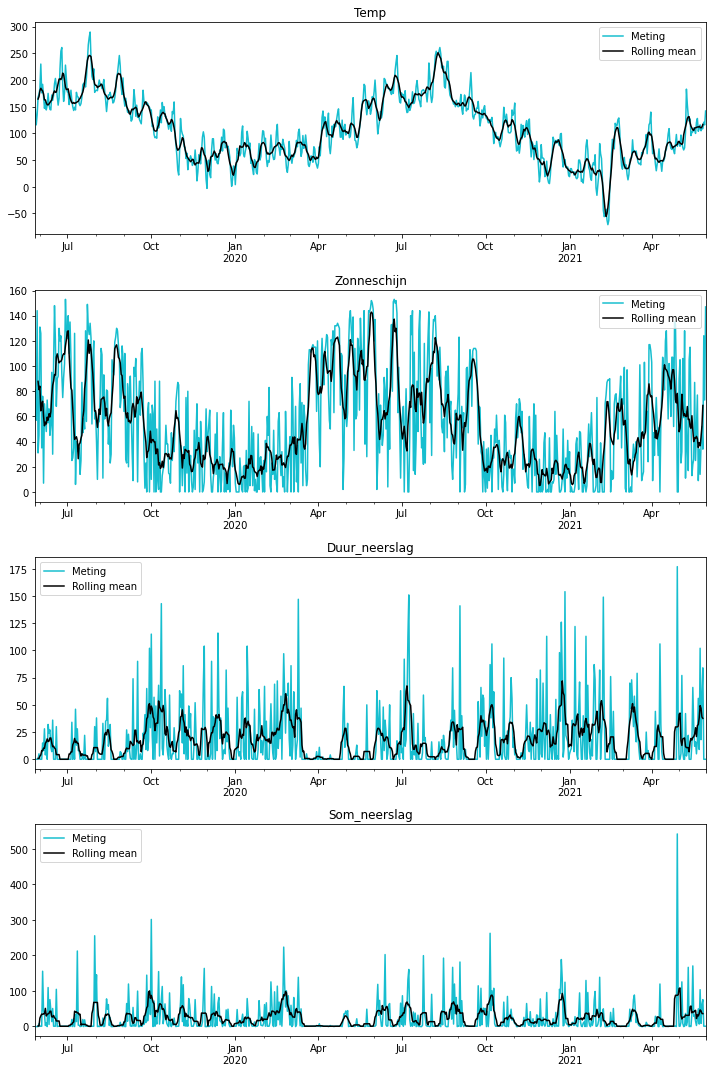

In [222]:
# Plot weer data met rolling mean
fig, ax = plt.subplots(4,1, figsize = (10,15))
# Dictionairy voor variabele met bijbehorende ax
dict_ax = {'temp' : ax[0],
           'zonneschijn' : ax[1],
           'duur_neerslag' : ax[2],
           'som_neerslag' : ax[3],
          }

for i in cols_w:
    # Plot originele data
    ts[i].plot(color = 'tab:cyan', label = 'Meting', 
               ax = dict_ax[i])
    # Plot rolling mean
    ts_rolling_w[i].plot(color = "k", label = "Rolling mean",
                         ax = dict_ax[i])
    dict_ax[i].set_title(i.capitalize())
    dict_ax[i].legend()
    
plt.tight_layout()
plt.show()

#### 2.2.1 Gemiddelden

In [223]:
# Labels voor in legenda
legend_labels_w = ['Temperatuur (0.1 graden Celsius)', 'Zonneschijnduur (0.1 uur)',
                   'Duur neerslag (0.1 uur)', 'Som neerslag (0.1 mm)']

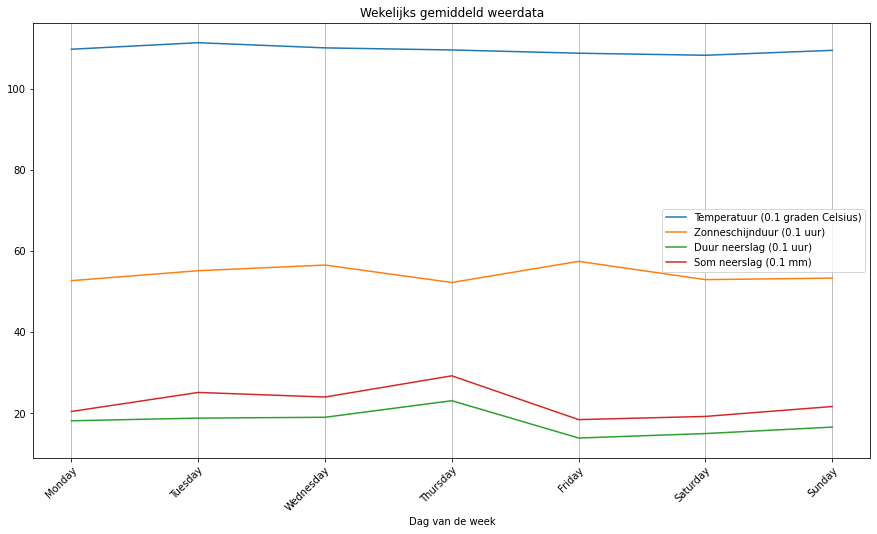

In [224]:
ts_grouped_gas = ts.groupby(['day_of_week', 'day_of_week_name'])[cols_w].mean().reset_index().set_index('day_of_week', drop= True)
ax = ts_grouped_gas.plot()

plt.title('Wekelijks gemiddeld weerdata')
plt.xlabel('Dag van de week')
plt.xticks(np.arange(0, 7),
           ts_grouped_gas['day_of_week_name'], 
           rotation = 45,
           ha = 'right', rotation_mode='anchor')

ax.legend(legend_labels_w)
plt.grid(axis = 'x')
plt.show()

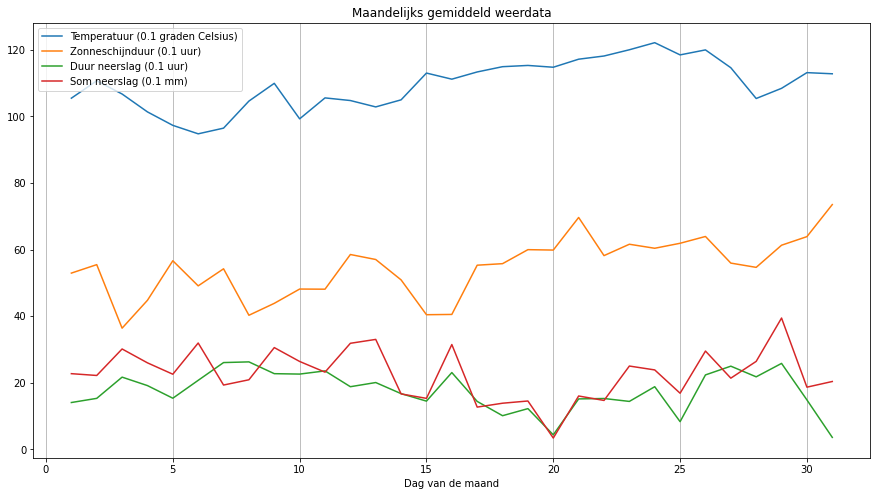

In [225]:
ts_grouped_w = ts.groupby('day_of_month')[cols_w].mean()#.reset_index().set_index('month', drop= True)
ax = ts_grouped_w.plot()

plt.title('Maandelijks gemiddeld weerdata')
plt.xlabel('Dag van de maand')
plt.grid(axis = 'x')

ax.legend(legend_labels_w)
plt.show()

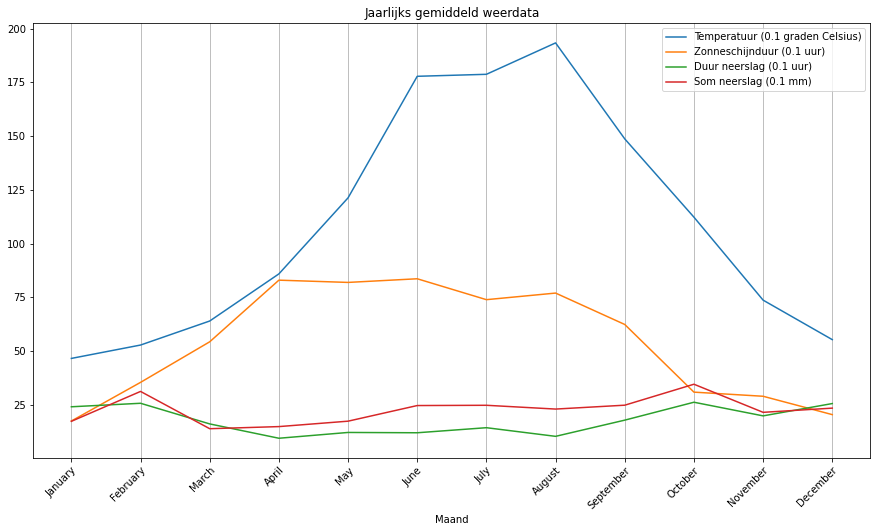

In [226]:
ts_grouped_w = ts.groupby(['month', 'month_name'])[cols_w].mean().reset_index().set_index('month', drop= True)
ax = ts_grouped_w.plot()

plt.title('Jaarlijks gemiddeld weerdata')
plt.xticks(np.arange(1, 13),
           ts_grouped_w['month_name'], 
           rotation = 45,
           ha = 'right', rotation_mode='anchor')
plt.xlabel('Maand')
plt.grid(axis = 'x')

ax.legend(legend_labels_w)
plt.show()

Weerdata heeft alleen jaarlijks seizoenspatroon.

### 2.3 Zonnepanelen en weer data samen

#### 2.3.1 Correlatie

In [227]:
# Drop NaN waarden, er zijn veel NaN waarden voor teruglevering omdat die later kwamen dan het gebruik van gas startte
ts.dropna(inplace = True)

In [228]:
ts.head()

,gas,stroom,teruglevering,temp,zonneschijn,duur_neerslag,som_neerslag,day_of_week,day_of_week_name,day_of_month,month,month_name,season
2021-05-29,1.0,4.0,20.0,116,73,0,0,5,Saturday,29,5,May,Spring
2021-05-28,0.0,3.0,25.0,121,124,0,0,4,Friday,28,5,May,Spring
2021-05-27,2.0,4.0,9.0,109,34,84,75,3,Thursday,27,5,May,Spring
2021-05-26,1.0,11.0,11.0,109,52,59,61,2,Wednesday,26,5,May,Spring
2021-05-25,0.0,7.0,13.0,105,37,18,8,1,Tuesday,25,5,May,Spring


In [229]:
# Nummerieke kolommen
cols = ['gas', 'stroom', 'teruglevering', 
        'temp', 'zonneschijn','duur_neerslag', 'som_neerslag']

In [230]:
# Correlatie van teruglevering met de andere variabelen, gesorteerd van positief naar negatief
ts_corr = ts[cols].corr()
corr_teruglevering = ts_corr.drop('teruglevering')[['teruglevering']].sort_values('teruglevering', ascending = False)
corr_teruglevering

,teruglevering
zonneschijn,0.881190
temp,0.516625
som_neerslag,-0.229179
duur_neerslag,-0.389007
stroom,-0.489764
gas,-0.611261


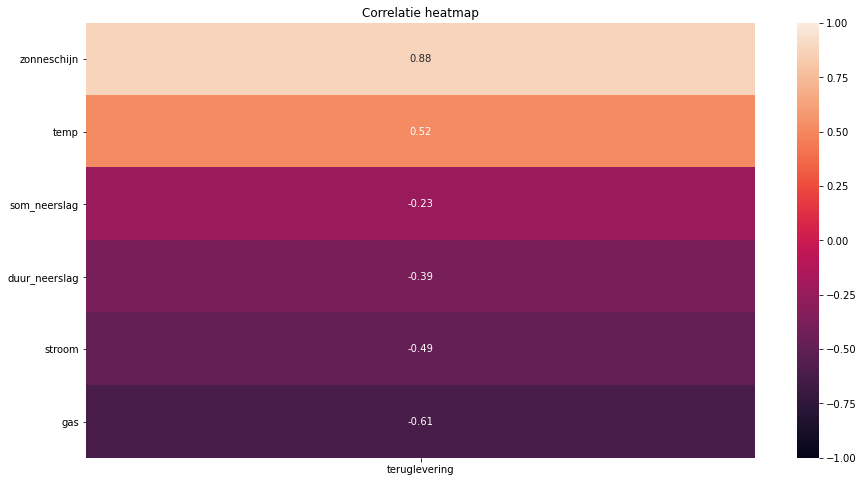

In [231]:
sns.heatmap(corr_teruglevering, annot = True, 
            vmin=-1, vmax=1 # Set range van kleur
           )
plt.title('Correlatie heatmap')
plt.yticks(rotation = 'horizontal')
plt.show()

In [232]:
ts_corr.loc['temp', 'zonneschijn']

0.3369995685480673

Teruglevering heeft een hoge positieve correlatie met zonneschijn en temperatuur, dus kunnen als extra variabelen toegevoegd worden aan het ARIMA model. Temperatuur en zonneschijn hebben een correlatie van 0.33, redelijk lage correlatie dus geen multicollineariteit.

Gas en stroom worden niet gebruikt om teruglevering te voorspellen; er wordt een weersvoorspelling gedaan voor dus op basiss daarvan kunnen we teruglevering voorspellen. Gas- en elektriciteitsverbruik is pas bekend aan het einde van de dag, en niet op het moment dat een voorspelling gedaan wordt.

#### 2.3.2 Verdere visualisaties met temperatuur en zonneschijn

In [233]:
corr_zon = ts_corr.loc['teruglevering', 'zonneschijn']
corr_temp = ts_corr.loc['teruglevering', 'temp']
print(corr_zon)
print(corr_temp)

0.8811900533042153
0.5166254631098118


##### 2.3.2.1 Teruglevering en zonneeschijn

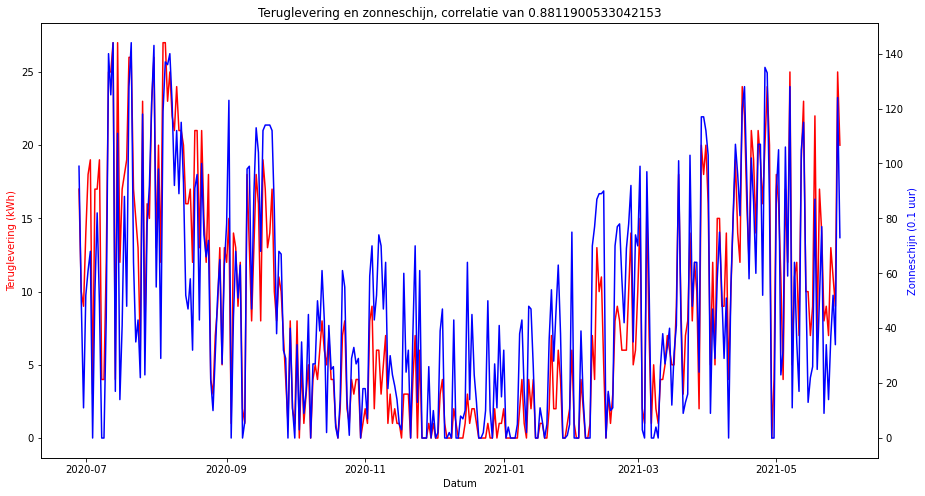

In [234]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(ts.teruglevering, 'r')
ax2.plot(ts.zonneschijn, 'b')

ax1.set_xlabel('Datum')
ax1.set_ylabel('Teruglevering (kWh)', color='r')
ax2.set_ylabel('Zonneschijn (0.1 uur)', color='b')

plt.title(f'Teruglevering en zonneschijn, correlatie van {corr_zon}')
plt.show()

##### Outliers obv variabelen delen op elkaar

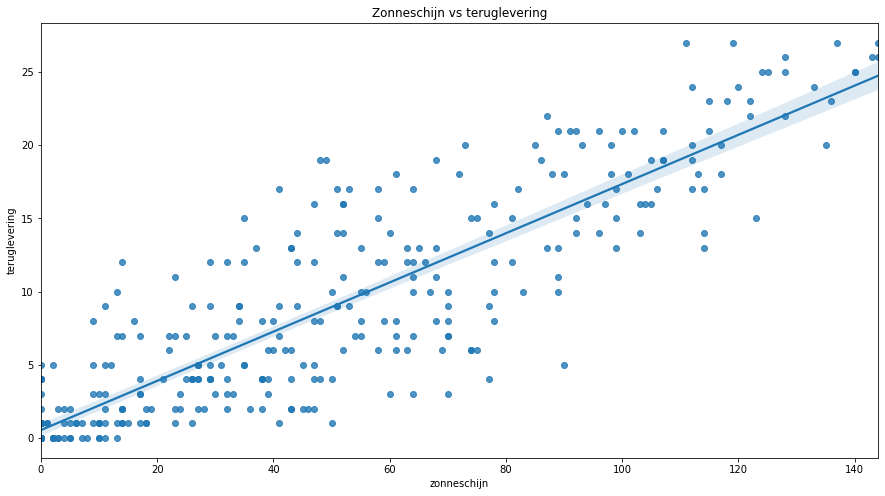

In [235]:
# Scatterplot
sns.regplot(data = ts, x = 'zonneschijn', y = 'teruglevering')
plt.title('Zonneschijn vs teruglevering')
plt.show()

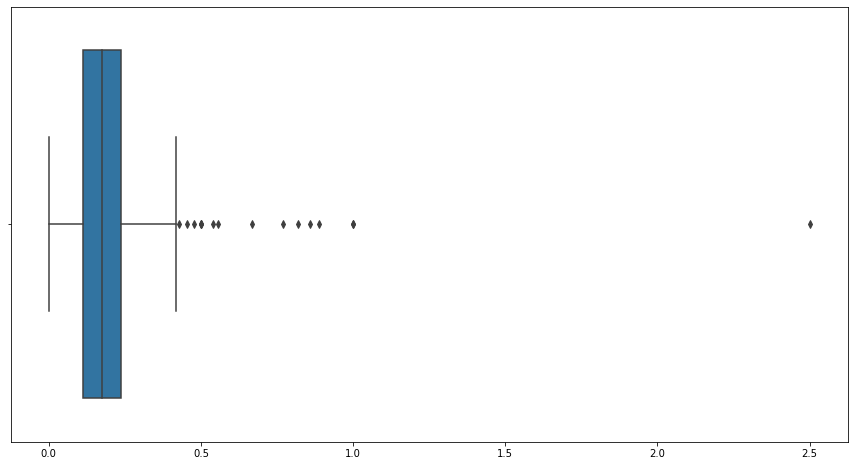

In [236]:
# Deel vars op elkaar en maak boxplot om te kijken wat uitschieter is
box_terug_vs_zon = ts.teruglevering / ts.zonneschijn
sns.boxplot(x = box_terug_vs_zon)
plt.show()

In [237]:
# https://datascience.stackexchange.com/questions/54808/how-to-remove-outliers-using-box-plot

# finding the 1st quartile
q1 = box_terug_vs_zon.quantile(0.25)
 
# finding the 3rd quartile
q3 = box_terug_vs_zon.quantile(0.75)
med = box_terug_vs_zon.median()
 
# finding the iqr region
iqr = q3-q1
 
# finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
print(lower_bound, iqr, upper_bound)

-0.06914787607425102 0.12216374695676885 0.4195071117528244


In [238]:
# Alles onder de lower en boven de upper zijn outliers
filter_zon = (box_terug_vs_zon <= lower_bound) & (box_terug_vs_zon >= upper_bound)
ts['anomaly_box_zon'] = filter_zon
ts.head()

,gas,stroom,teruglevering,temp,zonneschijn,duur_neerslag,som_neerslag,day_of_week,day_of_week_name,day_of_month,month,month_name,season,anomaly_box_zon
2021-05-29,1.0,4.0,20.0,116,73,0,0,5,Saturday,29,5,May,Spring,False
2021-05-28,0.0,3.0,25.0,121,124,0,0,4,Friday,28,5,May,Spring,False
2021-05-27,2.0,4.0,9.0,109,34,84,75,3,Thursday,27,5,May,Spring,False
2021-05-26,1.0,11.0,11.0,109,52,59,61,2,Wednesday,26,5,May,Spring,False
2021-05-25,0.0,7.0,13.0,105,37,18,8,1,Tuesday,25,5,May,Spring,False


##### 2.3.2.2 Teuglevering en temperatuur

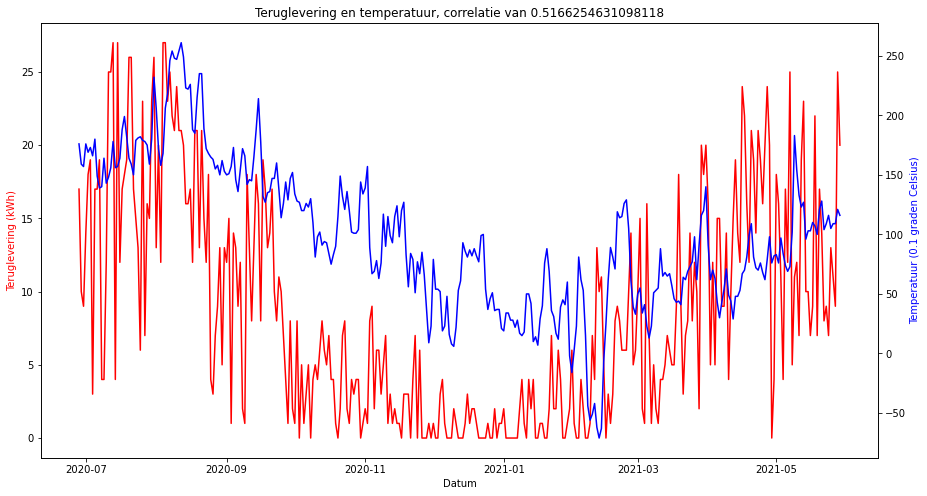

In [239]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(ts.teruglevering, 'r')
ax2.plot(ts.temp, 'b')

ax1.set_xlabel('Datum')
ax1.set_ylabel('Teruglevering (kWh)', color='r')
ax2.set_ylabel('Temperatuur (0.1 graden Celsius)', color='b')

plt.title(f'Teruglevering en temperatuur, correlatie van {corr_temp}')
plt.show()

##### Outliers obv variabelen delen op elkaar

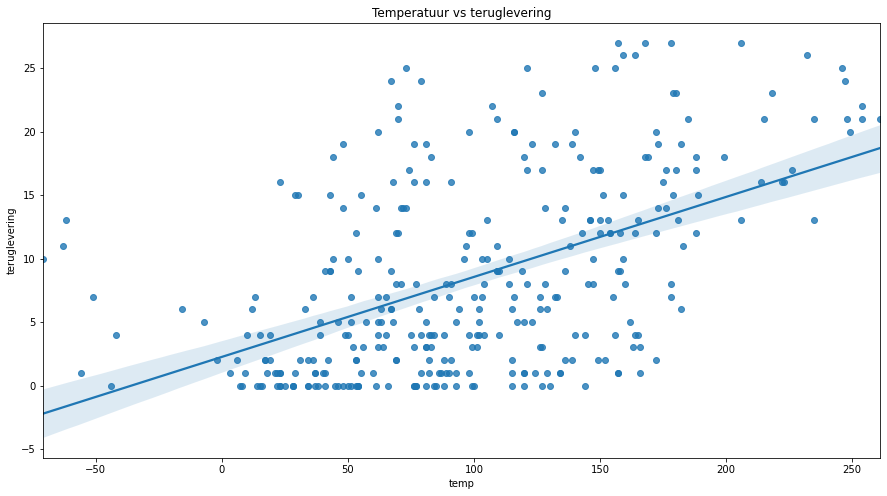

In [240]:
# Scatterplot
sns.regplot(data = ts, x = 'temp', y = 'teruglevering')
plt.title('Temperatuur vs teruglevering')
plt.show()

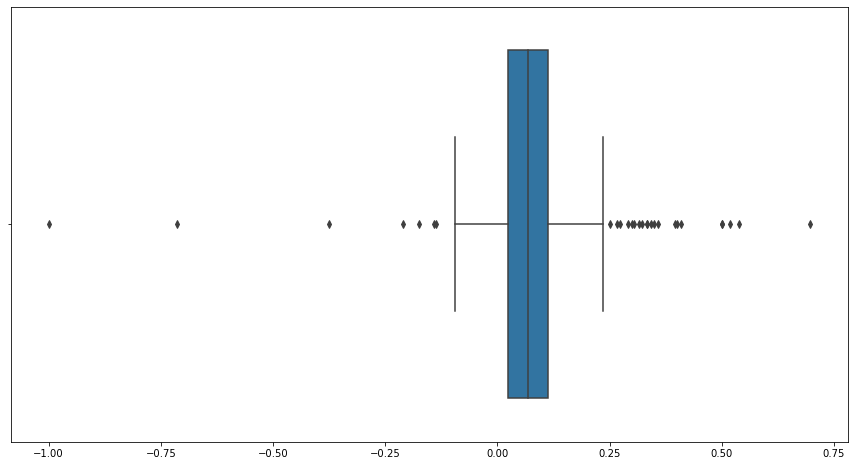

In [241]:
# Deel vars op elkaar en maak boxplot om te kijken wat uitschieter is
box_terug_vs_temp = ts.teruglevering / ts.temp
sns.boxplot(x = box_terug_vs_temp)
plt.show()

In [242]:
# https://datascience.stackexchange.com/questions/54808/how-to-remove-outliers-using-box-plot

# finding the 1st quartile
q1 = box_terug_vs_temp.quantile(0.25)
 
# finding the 3rd quartile
q3 = box_terug_vs_temp.quantile(0.75)
med = box_terug_vs_temp.median()
 
# finding the iqr region
iqr = q3-q1
 
# finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
print(lower_bound, iqr, upper_bound)

-0.1115298891586537 0.08995216184902849 0.24827875823746026


In [243]:
# Alles onder de lower en boven de upper zijn outliers
filter_zon = (box_terug_vs_temp <= lower_bound) & (box_terug_vs_temp >= upper_bound)
ts['anomaly_box_temp'] = filter_zon
ts.head()

,gas,stroom,teruglevering,temp,zonneschijn,duur_neerslag,som_neerslag,day_of_week,day_of_week_name,day_of_month,month,month_name,season,anomaly_box_zon,anomaly_box_temp
2021-05-29,1.0,4.0,20.0,116,73,0,0,5,Saturday,29,5,May,Spring,False,False
2021-05-28,0.0,3.0,25.0,121,124,0,0,4,Friday,28,5,May,Spring,False,False
2021-05-27,2.0,4.0,9.0,109,34,84,75,3,Thursday,27,5,May,Spring,False,False
2021-05-26,1.0,11.0,11.0,109,52,59,61,2,Wednesday,26,5,May,Spring,False,False
2021-05-25,0.0,7.0,13.0,105,37,18,8,1,Tuesday,25,5,May,Spring,False,False


Er is te zien dat zonneschijn en teruglevering bijna op elkaar zitten; de teruglevering is door zonnepanelen, dus dat is logisch. Ook hebben temperatuur en teruglevering een verglijkbare richting; ook logisch, want wanneer de zon schijnt is het (vaak) warm.

**Te verklaren variabele: Teruglevering op basis van zonnepanelen**

Extra variabelen ARIMA model:
- Zonneschijn (0.1 uur)
- Temperatuur (0.1 graden Celsius)

## 3 Outliers

Outlier detectie wordt gedaan obv isolation forest en DBSCAN.

In [244]:
# Kolommen die in het model worden verwerkt
cols_model = ['teruglevering', 'temp', 'zonneschijn']

In [245]:
from sklearn.preprocessing import StandardScaler

In [246]:
# Data schalen
scaler = StandardScaler()
np_scaled = scaler.fit_transform(ts[cols_model])#.values.reshape(-1, 1))
ts[['teruglevering_sc', 'temp_sc', 'zonneschijn_sc']] = np_scaled
ts[['teruglevering_sc', 'temp_sc', 'zonneschijn_sc']].head()

,teruglevering_sc,temp_sc,zonneschijn_sc
2021-05-29,1.526239,0.274087,0.649640
2021-05-28,2.189649,0.354985,1.939885
2021-05-27,0.066736,0.160831,-0.337018
2021-05-26,0.332100,0.160831,0.118363
2021-05-25,0.597464,0.096114,-0.261121


In [247]:
ts[['teruglevering_sc', 'temp_sc', 'zonneschijn_sc']].describe()

,teruglevering_sc,temp_sc,zonneschijn_sc
count,3.360000e+02,3.360000e+02,3.360000e+02
mean,-2.861468e-16,8.921435e-17,2.180795e-16
std,1.001491e+00,1.001491e+00,1.001491e+00
min,-1.127403e+00,-2.751468e+00,-1.197181e+00
25%,-8.620385e-01,-7.290378e-01,-9.188927e-01
50%,-1.986282e-01,-9.803969e-02,-1.599253e-01
75%,7.301462e-01,7.473360e-01,6.749389e-01
max,2.455013e+00,2.620106e+00,2.445863e+00


### 3.1 Isolation forest

- Anomaly = -1

In [248]:
from sklearn.ensemble import IsolationForest

In [249]:
cols_model_scaled = ['teruglevering_sc', 'temp_sc', 'zonneschijn_sc']

In [250]:
# Initialiseer en fit model
outliers_fraction = float(.05) # 5% van de data wordt gedefinieerd als outlier
model =  IsolationForest(contamination = outliers_fraction)
model.fit(ts[cols_model_scaled])

IsolationForest(contamination=0.05)

In [251]:
# Predict outliers
ts['anomaly_if'] = model.predict(ts[cols_model_scaled])
ts[['teruglevering_sc', 'temp_sc', 'zonneschijn_sc', 'anomaly_if']].head()

,teruglevering_sc,temp_sc,zonneschijn_sc,anomaly_if
2021-05-29,1.526239,0.274087,0.649640,1
2021-05-28,2.189649,0.354985,1.939885,1
2021-05-27,0.066736,0.160831,-0.337018,1
2021-05-26,0.332100,0.160831,0.118363,1
2021-05-25,0.597464,0.096114,-0.261121,1


In [252]:
ts.value_counts('anomaly_if')

anomaly_if
 1    319
-1     17
dtype: int64

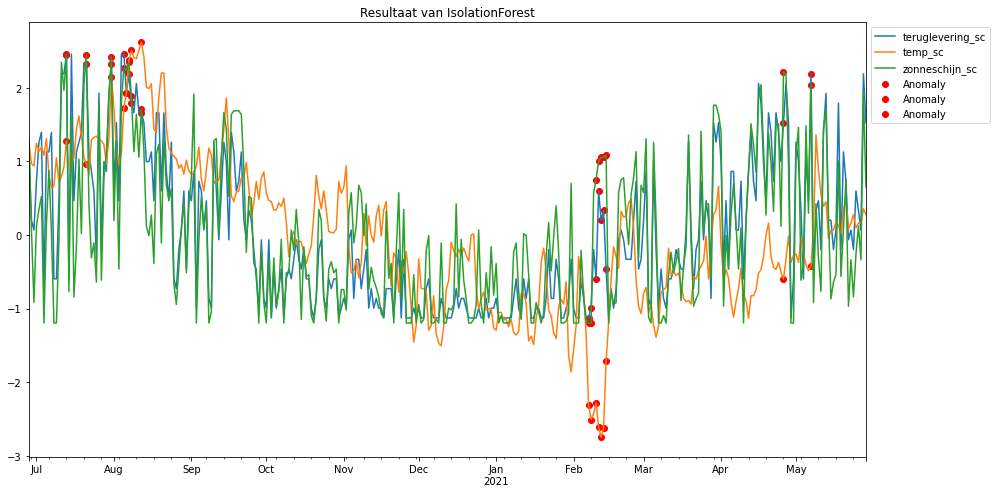

In [253]:
fig, ax = plt.subplots()

ts_anom = ts[ts['anomaly_if'] == -1]

ts[['teruglevering_sc', 'temp_sc', 'zonneschijn_sc']].plot(ax = ax)

for col in ['teruglevering_sc', 'temp_sc', 'zonneschijn_sc']:
    ax.scatter(ts_anom.index,
               ts_anom[col],
               c = 'r',
               label = 'Anomaly')

plt.title('Resultaat van IsolationForest')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

### 3.2 DBSCAN

In [254]:
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.neighbors import NearestNeighbors

In [255]:
dim = len(['teruglevering_sc', 'temp_sc', 'zonneschijn_sc'])
min_samples = 2 * dim
min_samples

6

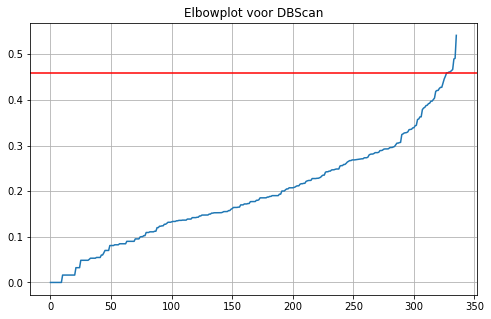

In [256]:
# Elbowplot om eps te schatten
neighbors = NearestNeighbors(n_neighbors = min_samples)
neighbors_fit = neighbors.fit(ts[cols_model_scaled])
distances, indices = neighbors_fit.kneighbors(ts[cols_model_scaled])

distances = np.sort(distances, axis=0)
distances = distances[:,1]

fig, ax = plt.subplots(figsize = (8,5))
plt.plot(distances)
plt.title('Elbowplot voor DBScan')
plt.axhline(y = 0.46, c = 'r')
plt.grid()
plt.show()

**Maar 0.46 is wel heel klein tov 0.8?**

In [257]:
# Initialiseer en fit model
model = DBSCAN(eps=0.8, min_samples = min_samples)
model.fit(ts[cols_model_scaled])

DBSCAN(eps=0.8, min_samples=6)

In [258]:
# Outliers
print(Counter(model.labels_))
ts['anomaly_db'] = model.labels_

Counter({0: 332, -1: 4})


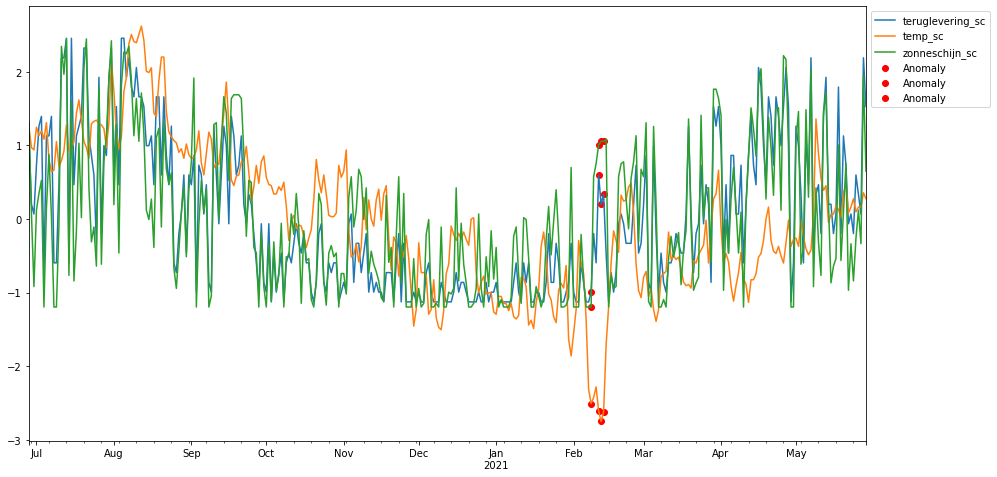

In [259]:
fig, ax = plt.subplots()

ts[['teruglevering_sc', 'temp_sc', 'zonneschijn_sc']].plot(ax = ax)

ts_anom = ts[ts['anomaly_db'] == -1]

for col in ['teruglevering_sc', 'temp_sc', 'zonneschijn_sc']:
    ax.scatter(ts_anom.index,
               ts_anom[col],
               c = 'r',
               label = 'Anomaly')
    
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

# Behandelen van outliers

1. Maak voor elke methode van outlier detectie een extra kolom waarin de outliers geïnterpoleerd zijn
2. Bekijk de acf en pacf en vergelijk met acf en pacf van originele data
3. De methode waarbij het minst veranderd wordt gekozen?

## 4 Model

- Te verklaren variabele: Teruglevering
- Extra verklarende variabelen: Zonneschijn en temperatuur.
- Misschien Fourier terms om seizoen te modelleren, omdat er maar één jaar aan data is?

### 4.1 Stationairiteit
Seasonal decompose kan niet uitgevoerd worden omdat er niet genoeg data is.

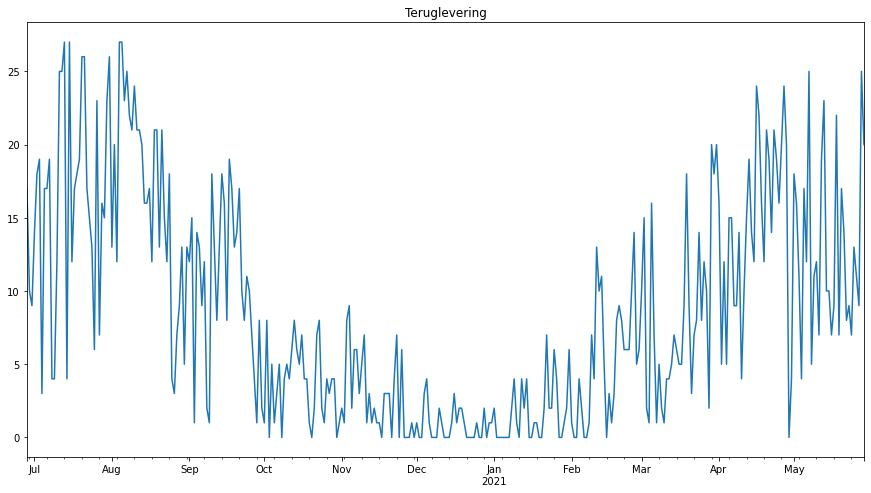

In [260]:
ts['teruglevering'].plot()
plt.title('Teruglevering')
plt.show()

In [261]:
# Voer adfullertest uit
res_stat = adfuller(ts['teruglevering'])

print('P-waarde adfuller test:')
print(res_stat[1])
print('In combinatie met de plot is conclusie dat de tijdreeks voor teruglevering (trend)stationair is.')

P-waarde adfuller test:
0.1386891300107993
In combinatie met de plot is conclusie dat de tijdreeks voor teruglevering (trend)stationair is.


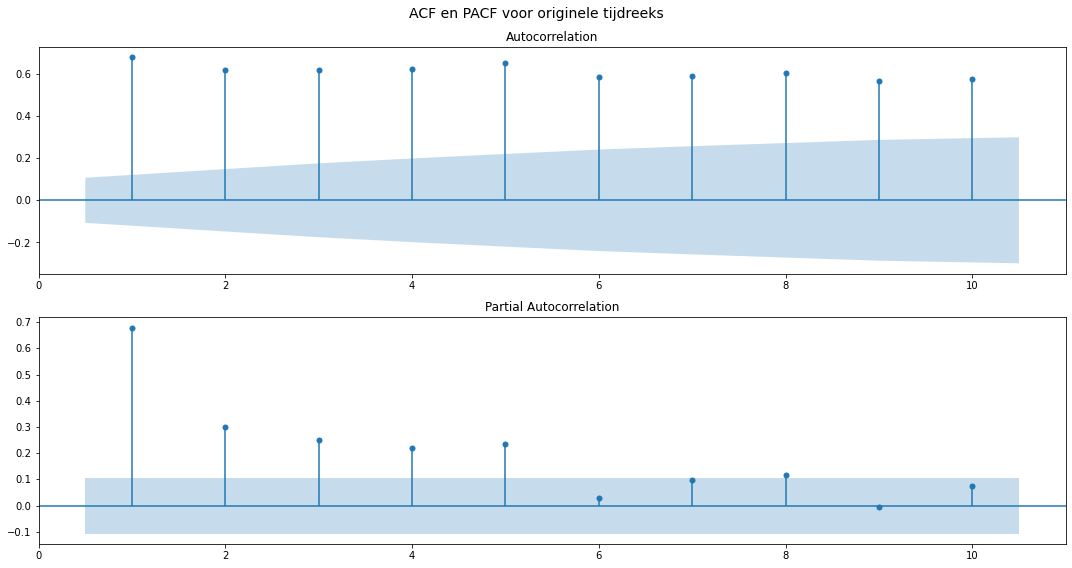

In [262]:
# ACF en PACF
fig, ax = plt.subplots(2,1)

plot_acf(ts['teruglevering'], lags = 10, zero = False, ax = ax[0])
plot_pacf(ts['teruglevering'], lags = 10, zero = False, ax = ax[1])
fig.suptitle('ACF en PACF voor originele tijdreeks', size = 14)
plt.tight_layout()
plt.show()

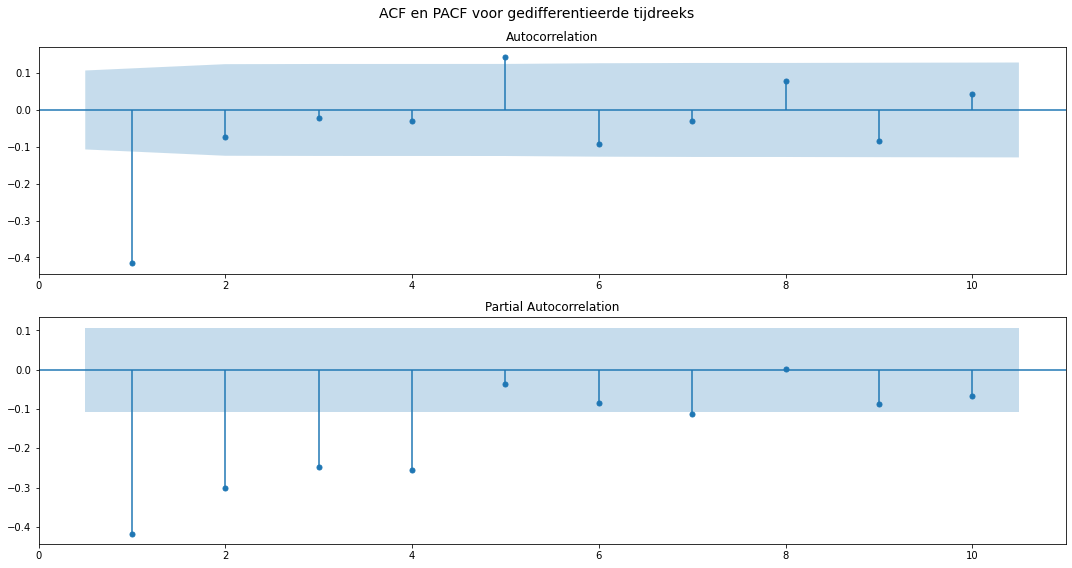

In [263]:
# ACF en PACF voor gedifferencieerde tijdreeks
fig, ax = plt.subplots(2,1)

plot_acf(ts['teruglevering'].diff().dropna(), lags = 10, zero = False, ax = ax[0])
plot_pacf(ts['teruglevering'].diff().dropna(), lags = 10, zero = False, ax = ax[1])
fig.suptitle('ACF en PACF voor gedifferentieerde tijdreeks', size = 14)
plt.tight_layout()
plt.show()

Dat is beter ja :) Gedifferencieerde tijdreeks wordt gebruikt voor de voorspelling, waarbij waarschijnlijk:

- p = 4
- q = 0

### 4.2 SARIMAX model bouwen
1. Als eerste worden er Fourier terms toegevoegd om het seizoenscomponent te modelleren. Dit is nodig omdat de dataset korter is dan twee jaar, en dus kan ARIMA het seizoen niet herkennen.
2. Tweede stap is om de extra voorspellende variabele zonneschijnuren toe te voegen en te bekijken of het model zo verbeterd is. Deze variabele wordt als eerste gekozen omdat die de hoogste correlatie heeft met teruglevering.
3. De laatste variabele die wordt toegevoegd is de temperatuur. Weer wordt er gekeken of dit verbetering opleverd.

Er wordt een dataset gemaakt met daarin de modellen en hun AIC- en MAPE-waarden. Het beste model wordt gekozen op basis van deze waarden, en met dat model wordt de voorspelling van een week gemaakt.

In [264]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [265]:
# Maak nieuwe dataset waarin alleen benodigde data staat
ts = ts[['teruglevering', 'zonneschijn', 'temp']]
ts.head(3)

,teruglevering,zonneschijn,temp
2021-05-29,20.0,73,116
2021-05-28,25.0,124,121
2021-05-27,9.0,34,109


In [266]:
print(f'Eerste datum in dataset: {ts.index.min()}')
print(f'Laatste datum in dataset: {ts.index.max()}')
print(f'Lengte dataset: {len(ts)}')

Eerste datum in dataset: 2020-06-28 00:00:00
Laatste datum in dataset: 2021-05-29 00:00:00
Lengte dataset: 336


We willen 7 dagen (één week) voorspellen en de dataset bevat 336 dagen. Op basis van deze informatie kiezen we voor een test-set van 35 dagen (vijf weken). Dit is minder dat 10% en is ongeveer een maand.

In [267]:
date_min = ts.index.min()
date_max = ts.index.max()
len_test = timedelta(days = 35)

De test-set moet 35 dagen zijn, dus de train-set eindigt één dag eerder.

In [268]:
ts_train = ts.loc[ts.index.max() - len_test - timedelta(days = 1):].copy()
ts_test = ts.loc[:ts.index.max() - len_test].copy()
ts_train.head()

,teruglevering,zonneschijn,temp
2021-04-23,21.0,107,70
2021-04-22,14.0,60,72
2021-04-21,19.0,86,81
2021-04-20,21.0,102,109
2021-04-19,12.0,58,99


In [269]:
ts_test.tail()

,teruglevering,zonneschijn,temp
2021-04-28,20.0,85,98
2021-04-27,24.0,133,79
2021-04-26,20.0,135,62
2021-04-25,16.0,52,68
2021-04-24,19.0,107,76


Train-set eindigt op de 23ste, test-set eindigt op de 24ste.

#### 4.2.1 Seizoenscomponent modelleren (Fourier Terms)
Omdat de dataset korter is dan twee jaar, kan een ARIMA-model niet zelf het jaarlijkse seizoenspatroon herkennen. Om dit op te lossen worden er Fourier terms gebruikt om het seizoenscomponent te modelleren.

In [270]:
# Initialieer nieuwe dataframe waarbij index dezelfde data heeft als teruglevering
df_exog = pd.DataFrame({'date': ts.index}) 
df_exog = df_exog.set_index('date')
df_exog.head(3)

""
date
2021-05-29
2021-05-28
2021-05-27


In [271]:
# Dictionairy waarin resultaten van auto_arima worden opgeslagen
dict_aa = {}

# Er wordt een loop doorlopen waarbij 1 tot en met 4 fourier terms worden toegevoegd aan het model
for k in np.arange(2, 10, 2):
    
    # Maak fourier terms aan
    df_exog[f'sin365_{int(k/2)}'] = np.sin(k * np.pi * df_exog.index.dayofyear / 365.25)
    df_exog[f'cos365_{int(k/2)}'] = np.cos(k * np.pi * df_exog.index.dayofyear / 365.25)
    
    # Train test split voor fourier terms
    exog_train = df_exog.iloc[-len(ts_train):]
    exog_test = df_exog.iloc[:len(ts_test)]
    
    # Auto arima doen
    res = pm.auto_arima(ts_train['teruglevering'], exogenous = exog_train,
                        d = 1, # Één keer differentiëren
                        start_p = 0, max_p = 2, # p is waarschijnlijk 4, dus we zoeken tussen 3 en 5
                        start_q = 1, max_q = 4, # q is waarchijnlik 1, dus we zoeken tussen 0 en 3
                        information_criterion = 'aic',# Beste model wordt gekozen obv aic
                        trace = True, error_action = 'ignore', stepwise = True
                       )
    # Beste model in dictionairy gooien
    dict_aa[k/2] = [res.order, res.aic()]
    print()
    
print('\nResultaten:')   
print(dict_aa)

Performing stepwise search to minimize aic
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1760.176, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1885.165, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1827.310, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1883.180, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1758.169, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1758.528, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1801.278, Time=0.24 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1757.436, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1758.984, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1825.348, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0

De laagste AIC is bij p = 1, d = 1 en q = 2 met 2 Fourier terms. Er wordt dus gekozen voor **twee** Fourier Terms.

In [272]:
aantal_fourier = 2
fourier_cols = df_exog.columns[0:2*aantal_fourier]
fourier_cols

Index(['sin365_1', 'cos365_1', 'sin365_2', 'cos365_2'], dtype='object')

In [273]:
# Voeg de fourier terms toe aan originele ts
ts[fourier_cols] = df_exog[fourier_cols]

# Opnieuw train-test split doen want fourier terms staan er nu niet in 
ts_train = ts.loc[ts.index.max() - len_test - timedelta(days = 1):]
ts_test = ts.loc[:ts.index.max() - len_test]
ts_train.head(3)

,teruglevering,zonneschijn,temp,sin365_1,cos365_1,sin365_2,cos365_2
2021-04-23,21.0,107,70,0.931210,-0.364483,-0.678820,-0.734304
2021-04-22,14.0,60,72,0.937342,-0.348411,-0.653160,-0.757220
2021-04-21,19.0,86,81,0.943196,-0.332235,-0.626727,-0.779239


In [274]:
# Auto-ARIMA met X var
res_fourier = pm.auto_arima(ts_train['teruglevering'], 
                        d = 1,
                        start_p = 0, max_p = 2,
                        start_q = 2, max_q = 3,
                        exogenous = ts_train[fourier_cols],
                        information_criterion = 'aic', trace = True, 
                        error_action = 'ignore', stepwise = True
                       )
print(res_fourier.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1889.131, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1831.216, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1761.626, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1887.164, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1751.583, Time=0.70 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1763.459, Time=1.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.58 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 8.001 seconds
                               SARIMAX Results           

In [275]:
# Maak df met daarin alleen fourier terms vermenigvuldigd met hun coeff zodat ze gevisualiseerd kunnen worden
df_fourier = pd.DataFrame()

# Krijg coeff
coeff_S1 = res_fourier.params()[1]
coeff_C1 = res_fourier.params()[2]
coeff_S2 = res_fourier.params()[3]
coeff_C2 = res_fourier.params()[4]

# Vermenigvuldig coeff met bijbehorende term
df_fourier['S1'] = coeff_S1 * ts[fourier_cols[0]]
df_fourier['C1'] = coeff_C1 * ts[fourier_cols[1]]
df_fourier['S2'] = coeff_S2 * ts[fourier_cols[2]]
df_fourier['C2'] = coeff_C2 * ts[fourier_cols[3]]

# Tel terms met dezelfde periode bij elkaar op
df_fourier['Fourier_1'] = df_fourier['S1'] + df_fourier['C1']
df_fourier['Fourier_2'] = df_fourier['S2'] + df_fourier['C2']
# Totale gemodelleerde seizoenscomponent door fourier terms
df_fourier['Fourier_total'] = df_fourier['Fourier_1'] + df_fourier['Fourier_2']

df_fourier.head(3)

,S1,C1,S2,C2,Fourier_1,Fourier_2,Fourier_total
2021-05-29,-2.703744,10.584906,-1.304459,1.112143,7.881162,-0.192316,7.688846
2021-05-28,-2.774575,10.464456,-1.323399,1.024405,7.689882,-0.298995,7.390887
2021-05-27,-2.844584,10.340910,-1.340774,0.935454,7.496326,-0.405319,7.091007


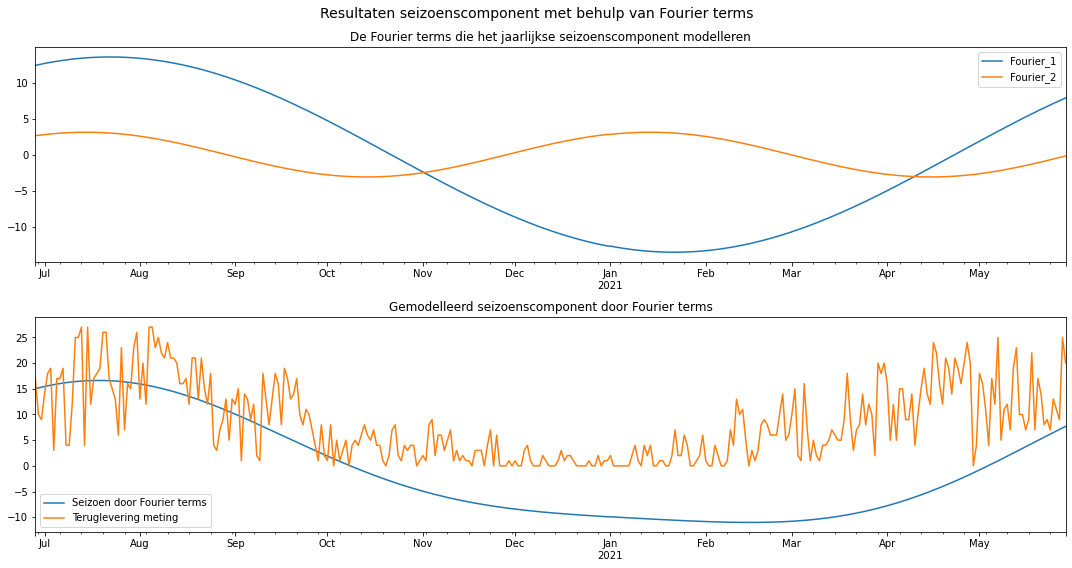

In [276]:
fig, ax = plt.subplots(2,1)

df_fourier[['Fourier_1', 'Fourier_2']].plot(ax = ax[0])
ax[0].set_title('De Fourier terms die het jaarlijkse seizoenscomponent modelleren')

df_fourier['Fourier_total'].plot(ax = ax[1], label = 'Seizoen door Fourier terms')
ts['teruglevering'].plot(ax = ax[1], label = 'Teruglevering meting')
ax[1].set_title('Gemodelleerd seizoenscomponent door Fourier terms')
ax[1].legend()

fig.suptitle('Resultaten seizoenscomponent met behulp van Fourier terms', size = 14)
plt.tight_layout()
plt.show()

Het seizoenscomponent  is veel te laag na oktober en moet ook niet negatief kunnen worden. **What to do?**

# Voorspellingen, maar maar beetje whack

In [277]:
ts_test['pred_fourier'] = res_fourier.predict(len(ts_test), exogenous = ts_test[fourier_cols])
ts_test.head(3)

C:\Users\Lea\Programs\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
<ipython-input-277-10d3162034ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_test['pred_fourier'] = res_fourier.predict(len(ts_test), exogenous = ts_test[fourier_cols])


,teruglevering,zonneschijn,temp,sin365_1,cos365_1,sin365_2,cos365_2,pred_fourier
2021-05-29,20.0,73,116,0.546711,-0.837321,-0.915546,0.402214,6.439273
2021-05-28,25.0,124,121,0.561034,-0.827793,-0.928839,0.370483,6.056576
2021-05-27,9.0,34,109,0.575190,-0.818020,-0.941034,0.338313,5.676202


In [278]:
ts_train['pred_fourier'] = res_fourier.predict_in_sample(exogenous = ts_train[fourier_cols])
ts_train.head(3)

<ipython-input-278-a128f7e0c2c5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_train['pred_fourier'] = res_fourier.predict_in_sample(exogenous = ts_train[fourier_cols])


,teruglevering,zonneschijn,temp,sin365_1,cos365_1,sin365_2,cos365_2,pred_fourier
2021-04-23,21.0,107,70,0.931210,-0.364483,-0.678820,-0.734304,-3.067471
2021-04-22,14.0,60,72,0.937342,-0.348411,-0.653160,-0.757220,20.667150
2021-04-21,19.0,86,81,0.943196,-0.332235,-0.626727,-0.779239,16.690955


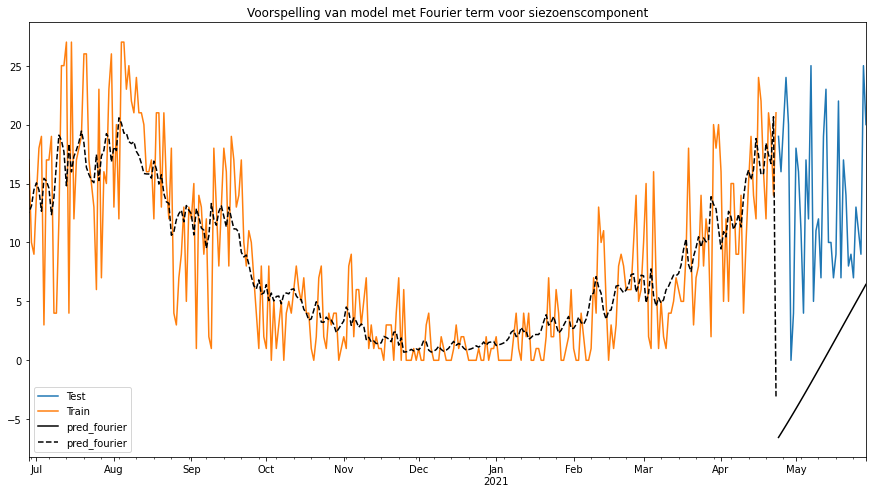

In [279]:
ax = ts_test['teruglevering'].plot(label = 'Test') # Testset 
ts_train['teruglevering'].plot(label = 'Train', ax = ax) # Train set
ts_test['pred_fourier'].plot(color = 'k') # Voorspelling
ts_train['pred_fourier'].plot(ax=ax, style='--', color='k', legend = False) # In sample pred voor train

ax.set_xlim([ts_train.index.min(), ts_test.index.max()])
plt.title('Voorspelling van model met Fourier term voor siezoenscomponent')
plt.legend()
plt.show()

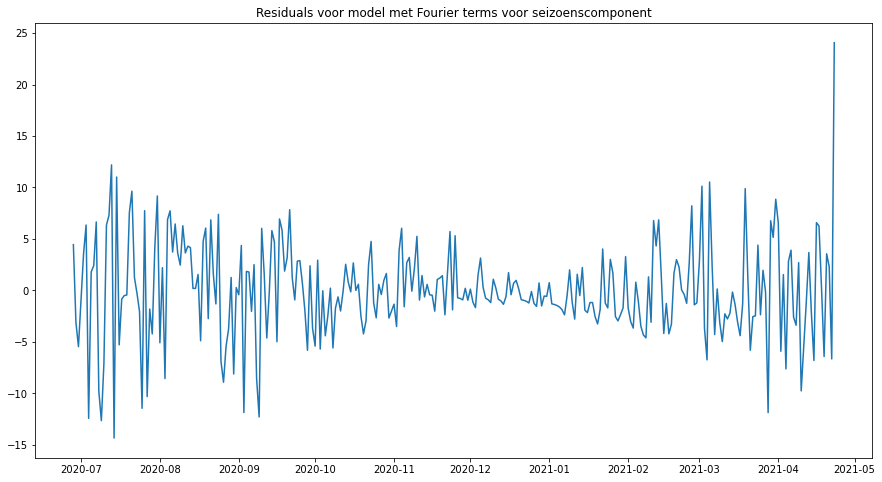

In [280]:
fig, ax = plt.subplots()
ax.plot(ts_train.index, res_fourier.resid())
plt.title('Residuals voor model met Fourier terms voor seizoenscomponent')
plt.show()

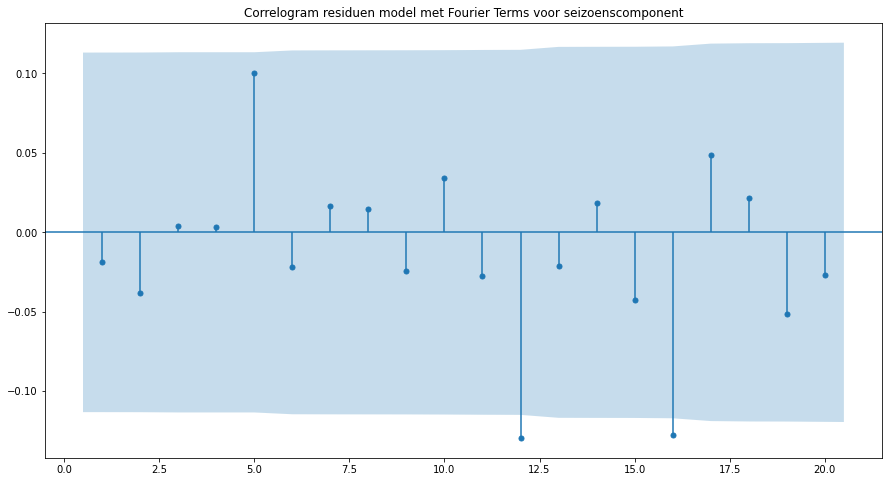

In [281]:
plot_acf(res_fourier.resid(), zero = False, lags = 20)
plt.title("Correlogram residuen model met Fourier Terms voor seizoenscomponent")
plt.show()

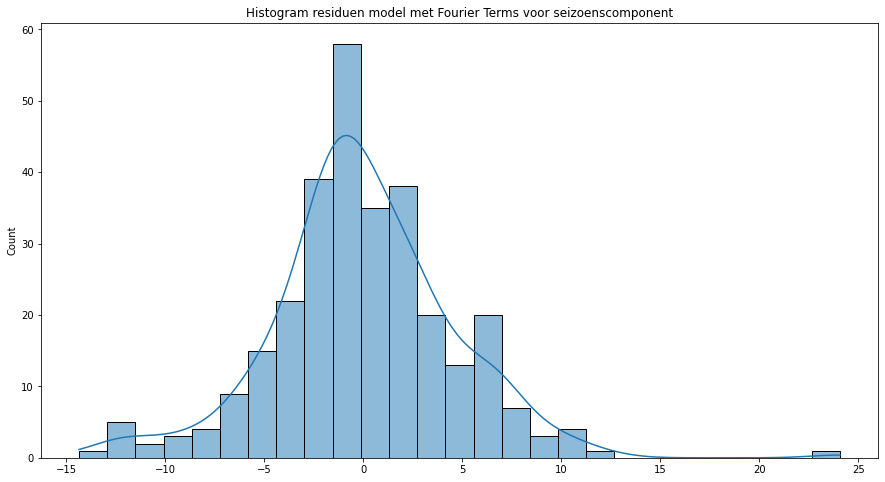

In [282]:
sns.histplot(res_fourier.resid(), kde = True, label = "Residuals")
plt.title('Histogram residuen model met Fourier Terms voor seizoenscomponent')
plt.show()

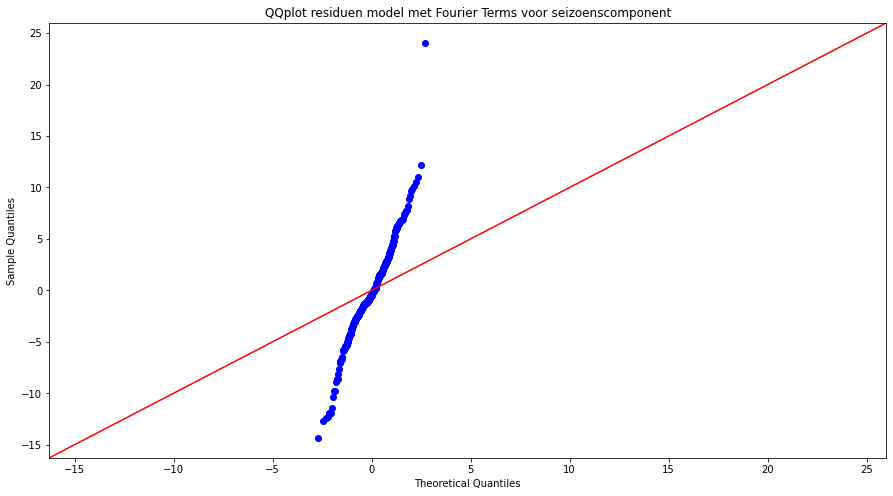

In [283]:
qqplot(res_fourier.resid(), line = '45')
plt.title('QQplot residuen model met Fourier Terms voor seizoenscomponent')
plt.show()

Het model ziet er niet zo goed uit, dus misschien beter om voorspellende variabelen te gebruiken ipv seizoenscomponent te modelleren met Fourier terms.

#### 4.2.2 Tweede model met zonneschijnuren als voorspellende variabele, zonder Fourier Terms

Zonneschijnuren heeft de hoogste correlatie met de teruglevering van zonnepanelen, daarom is dit de eerste variabele die we gebruiken als voorspellende variabele. In het volgende model wordt ook temperatuur toegevoegd, om te kijken of dit een verbetering geeft op de voorspelling.

##### 4.2.2.1 Het eerste model is gemaakt op basis van de ACF en PACF plots.

In [284]:
ts_train.head(3)

,teruglevering,zonneschijn,temp,sin365_1,cos365_1,sin365_2,cos365_2,pred_fourier
2021-04-23,21.0,107,70,0.931210,-0.364483,-0.678820,-0.734304,-3.067471
2021-04-22,14.0,60,72,0.937342,-0.348411,-0.653160,-0.757220,20.667150
2021-04-21,19.0,86,81,0.943196,-0.332235,-0.626727,-0.779239,16.690955


In [285]:
# Afgelezen uit ACF en PACF: p = 4, d = 1 en q = 0
res_zon1 = SARIMAX(ts_train['teruglevering'], 
                   order = (4,1,0),
                   exog = ts_train[['zonneschijn']],
                   trend = None
                  ).fit()

res_zon1.summary()

C:\Users\Lea\Programs\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\Lea\Programs\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          teruglevering   No. Observations:                  300
Model:               SARIMAX(4, 1, 0)   Log Likelihood                -646.858
Date:                Fri, 31 Dec 2021   AIC                           1305.716
Time:                        16:11:07   BIC                           1327.918
Sample:                             0   HQIC                          1314.602
                                - 300                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
zonneschijn     0.1211      0.003     37.265      0.000       0.115       0.127
ar.L1          -0.8477      0.060    -14.039      0.000      -0.966      -0.729
ar.L2          -0.6906      0.070     -9.815      0.000      -0.828      -0.553
ar.L3          -0.4309      0.061     -7.099      0.000      -0.550      -0.312
ar.L4          -0.1560      0.050     -3.093      0.002      -0.255      -0.057
sigma2          4.4176      0.294     15.015      0.000       3.841       4.994
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                25.49
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                            -0.32
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [286]:
ts_train['pred_zon1'] = res_zon1.predict(exogenous = ts_train[['zonneschijn']])
ts_train.head(3)

<ipython-input-286-57006c2894cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_train['pred_zon1'] = res_zon1.predict(exogenous = ts_train[['zonneschijn']])


,teruglevering,zonneschijn,temp,sin365_1,cos365_1,sin365_2,cos365_2,pred_fourier,pred_zon1
2021-04-23,21.0,107,70,0.931210,-0.364483,-0.678820,-0.734304,-3.067471,12.958690
2021-04-22,14.0,60,72,0.937342,-0.348411,-0.653160,-0.757220,20.667150,15.307835
2021-04-21,19.0,86,81,0.943196,-0.332235,-0.626727,-0.779239,16.690955,17.789990


In [287]:
pred_zon1 = res_zon1.forecast(len(ts_test), exog = ts_test[['zonneschijn']])
pred_zon1[:5]

C:\Users\Lea\Programs\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


300    15.987950
301    21.226983
302     9.768124
303    11.982372
304    10.593274
Name: predicted_mean, dtype: float64

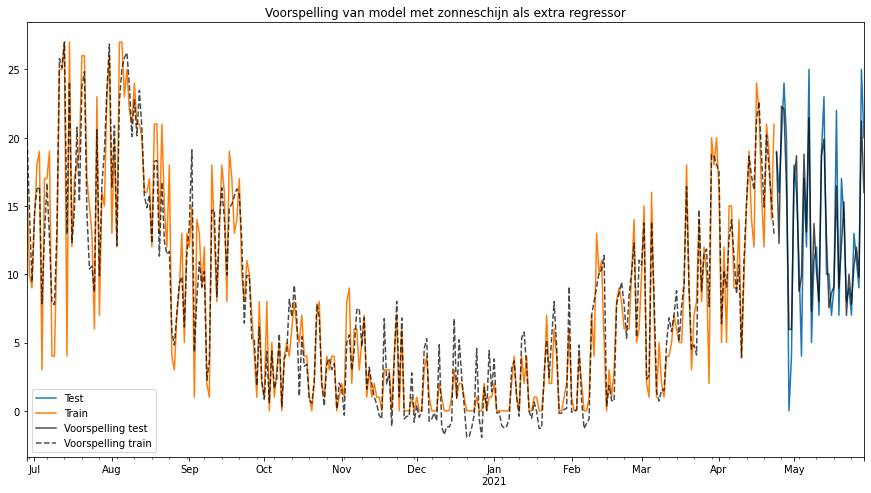

In [288]:
ax = ts_test['teruglevering'].plot(label = 'Test') # Testset 
ts_train['teruglevering'].plot(label = 'Train', ax = ax) # Train set

ax.plot(ts_test.index, pred_zon1, color = 'k', 
        label = 'Voorspelling test', alpha = 0.7) # Voorspelling

ts_train['pred_zon1'].plot(ax=ax, style='--', color='k', # In sample pred voor train
                           label = 'Voorspelling train', alpha = 0.7) 

ax.set_xlim([ts_train.index.min(), ts_test.index.max()])
plt.title('Voorspelling van model met zonneschijn als extra regressor')
plt.legend()
plt.show()

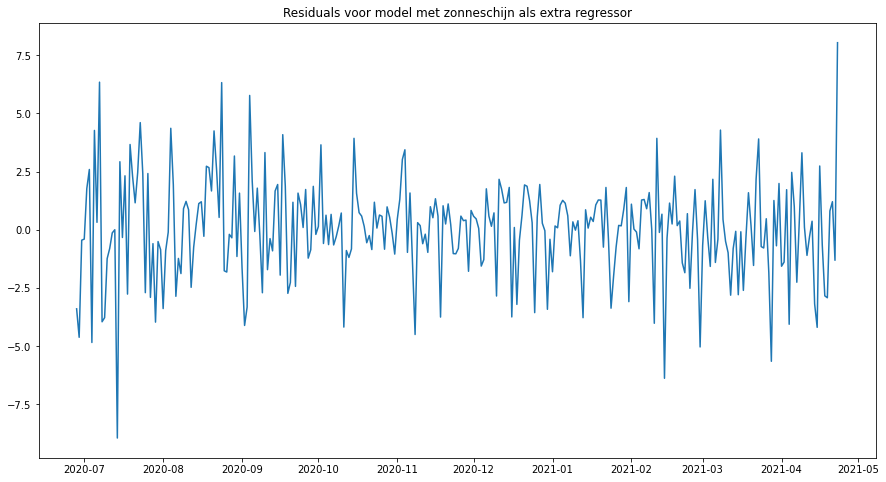

In [289]:
fig, ax = plt.subplots()
ax.plot(ts_train.index, res_zon1.resid)
plt.title('Residuals voor model met zonneschijn als extra regressor')
plt.show()

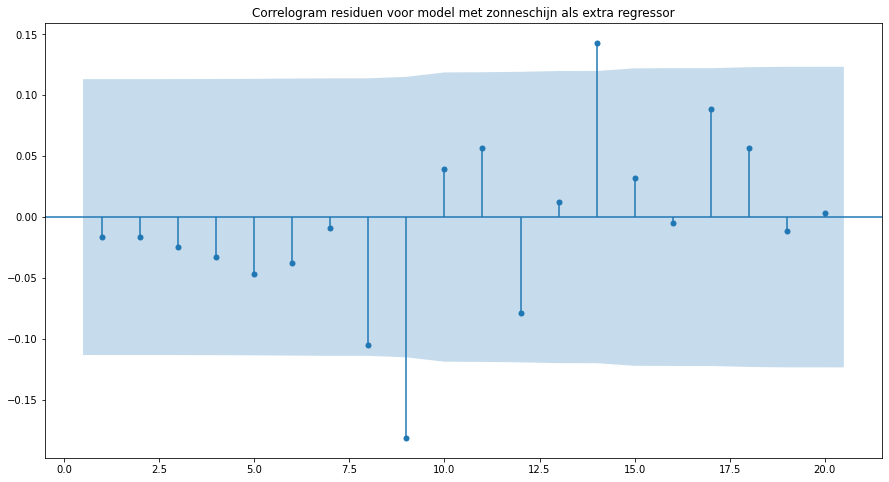

In [290]:
plot_acf(res_zon1.resid, zero = False, lags = 20)
plt.title("Correlogram residuen voor model met zonneschijn als extra regressor")
plt.show()

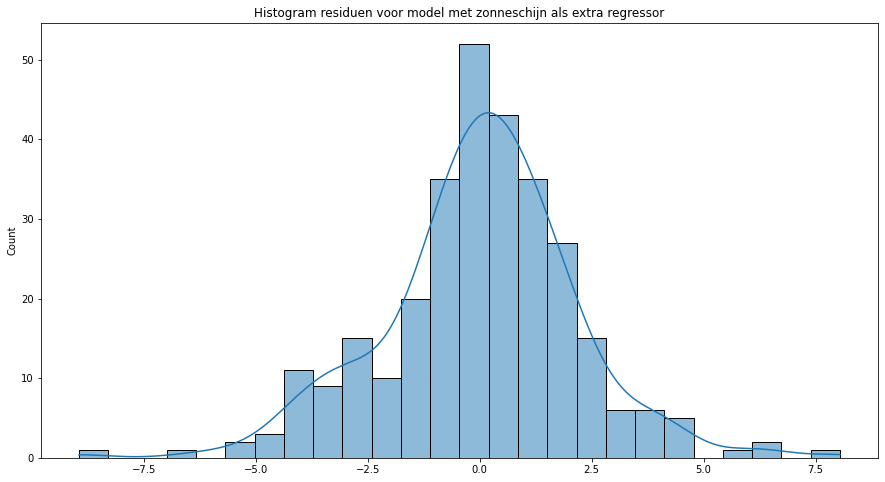

In [291]:
sns.histplot(res_zon1.resid, kde = True, label = "Residuals")
plt.title('Histogram residuen voor model met zonneschijn als extra regressor')
plt.show()

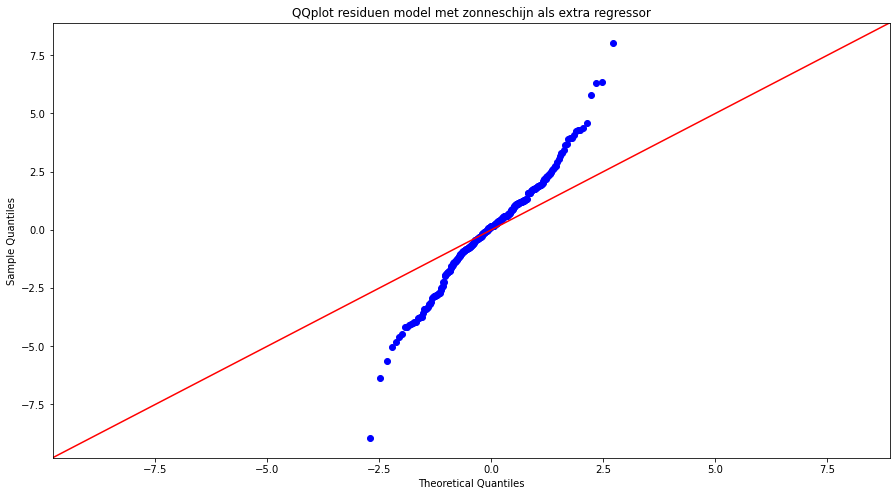

In [292]:
qqplot(res_zon1.resid, line = '45')
plt.title('QQplot residuen model met zonneschijn als extra regressor')
plt.show()

Er is informatie niet verwerkt in het model, te zien aan de correlogram die nog hoge correlatie heeft bij lags 9 en 14. Ook is er nog een patroon te herkennen in de residuen tov de tijd. Het model voorspelt ooko negatief terwijl dat niet mogelijk moet zijn.

##### 4.2.2.2 Model obv auto arima

In [293]:
# Auto-ARIMA met X var
res_zon2 = pm.auto_arima(ts_train['teruglevering'], 
                        d = 1,
                        start_p = 4, max_p = 6,
                        start_q = 0, max_q = 1,
                        exogenous = ts_train[['zonneschijn']],
                        information_criterion = 'aic', trace = True, 
                        error_action = 'ignore', stepwise = True
                       )
res_zon2.summary()

Performing stepwise search to minimize aic
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1307.692, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1459.537, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1382.653, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1305.269, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1457.541, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1306.468, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1303.271, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1304.468, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1380.663, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.434 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  300
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -648.635
Date:                Fri, 31 Dec 2021   AIC                           1303.271
Time:                        16:11:10   BIC                           1314.372
Sample:                             0   HQIC                          1307.714
                                - 300                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
zonneschijn     0.1250      0.003     38.608      0.000       0.119       0.131
ma.L1          -0.8036      0.030    -26.731      0.000      -0.863      -0.745
sigma2          4.4698      0.312     14.321      0.000       3.858       5.082
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):                19.10
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               1.58   Skew:                            -0.36
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [294]:
ts_train['pred_zon2'] = res_zon2.predict_in_sample(exogenous = ts_train[['zonneschijn']])
ts_train.head(3)

<ipython-input-294-7470fd773009>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_train['pred_zon2'] = res_zon2.predict_in_sample(exogenous = ts_train[['zonneschijn']])


,teruglevering,zonneschijn,temp,sin365_1,cos365_1,sin365_2,cos365_2,pred_fourier,pred_zon1,pred_zon2
2021-04-23,21.0,107,70,0.931210,-0.364483,-0.678820,-0.734304,-3.067471,12.958690,13.376832
2021-04-22,14.0,60,72,0.937342,-0.348411,-0.653160,-0.757220,20.667150,15.307835,15.124168
2021-04-21,19.0,86,81,0.943196,-0.332235,-0.626727,-0.779239,16.690955,17.789990,17.799354


In [295]:
ts_test['pred_zon2'] = res_zon2.predict(len(ts_test), exogenous = ts_test[['zonneschijn']])
ts_test.head(3)

C:\Users\Lea\Programs\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
<ipython-input-295-8065334fa2df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_test['pred_zon2'] = res_zon2.predict(len(ts_test), exogenous = ts_test[['zonneschijn']])


,teruglevering,zonneschijn,temp,sin365_1,cos365_1,sin365_2,cos365_2,pred_fourier,pred_zon2
2021-05-29,20.0,73,116,0.546711,-0.837321,-0.915546,0.402214,6.439273,15.830657
2021-05-28,25.0,124,121,0.561034,-0.827793,-0.928839,0.370483,6.056576,22.206530
2021-05-27,9.0,34,109,0.575190,-0.818020,-0.941034,0.338313,5.676202,10.954989


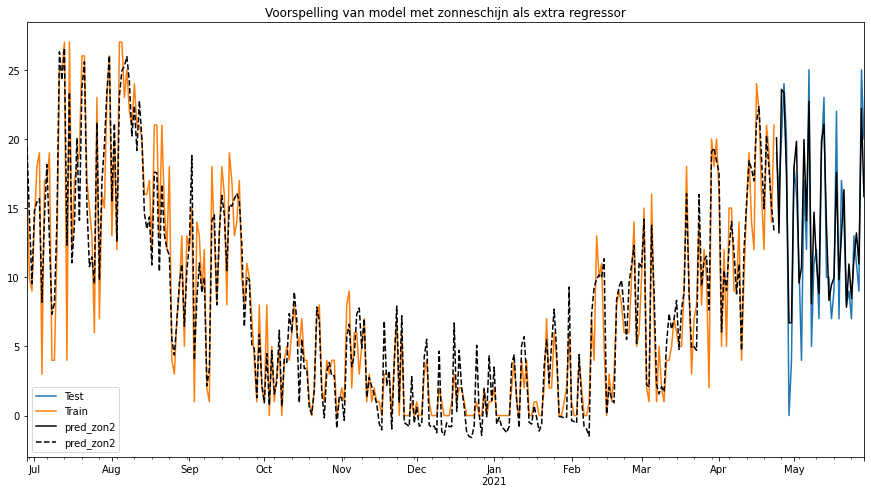

In [296]:
ax = ts_test['teruglevering'].plot(label = 'Test') # Testset 
ts_train['teruglevering'].plot(label = 'Train', ax = ax) # Train set
ts_test['pred_zon2'].plot(color = 'k') # Voorspelling
ts_train['pred_zon2'].plot(ax=ax, style='--', color='k', legend = False) # In sample pred voor train

ax.set_xlim([ts_train.index.min(), ts_test.index.max()])
plt.title('Voorspelling van model met zonneschijn als extra regressor')
plt.legend()
plt.show()

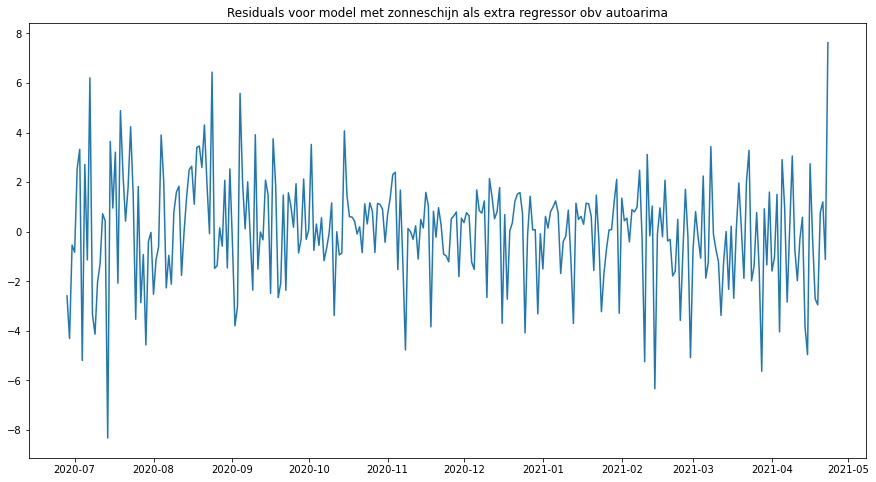

In [299]:
fig, ax = plt.subplots()
ax.plot(ts_train.index, res_zon2.resid())
plt.title('Residuals voor model met zonneschijn als extra regressor obv autoarima')
plt.show()

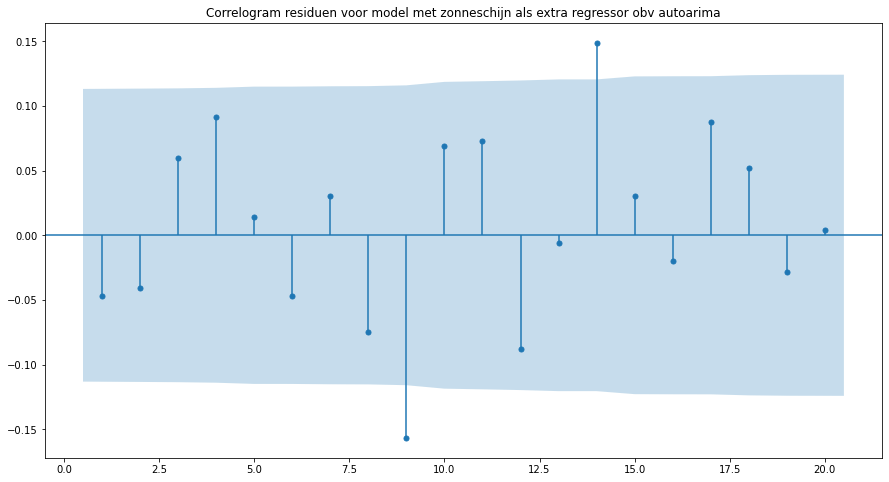

In [304]:
plot_acf(res_zon2.resid(), zero = False, lags = 20)
plt.title("Correlogram residuen voor model met zonneschijn als extra regressor obv autoarima")
plt.show()

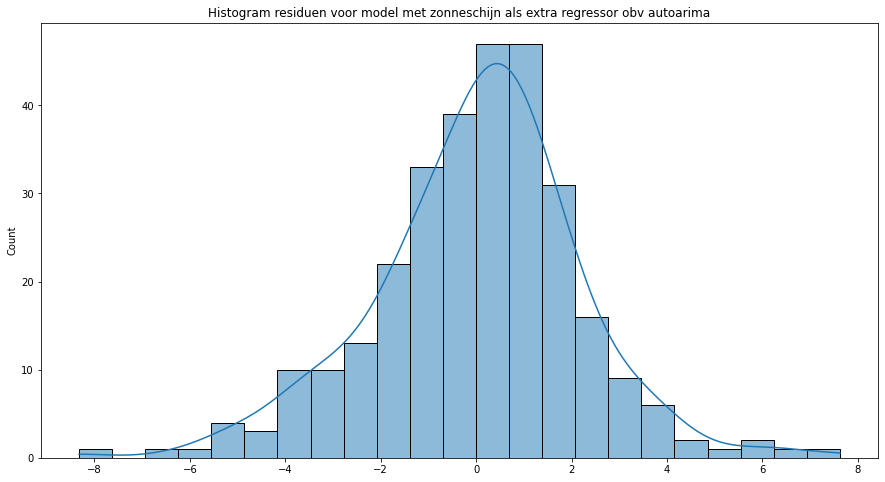

In [303]:
sns.histplot(res_zon2.resid(), kde = True, label = "Residuals")
plt.title('Histogram residuen voor model met zonneschijn als extra regressor obv autoarima')
plt.show()

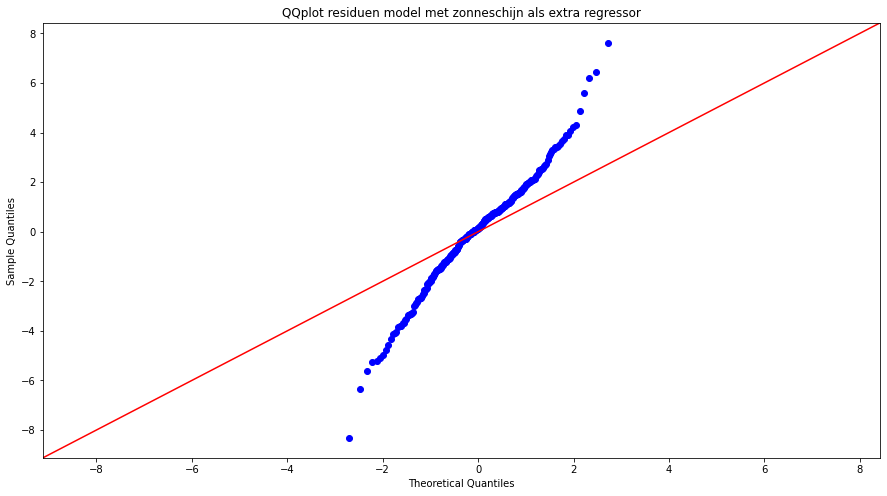

In [302]:
qqplot(res_zon2.resid(), line = '45')
plt.title('QQplot residuen model met zonneschijn als extra regressor')
plt.show()

Zelfde conclusie als bij p en q zelf afgelezen: Er is informatie niet verwerkt in het model, te zien aan de correlogram die nog hoge correlatie heeft bij lags 9 en 14. Ook is er nog een patroon te herkennen in de residuen tov de tijd.

#### 4.2.3 Derde model met zonneschijnuren en Fourier terms als seizoen
Levert het toevoegen van Fourier terms een verbetering op? Ff kieken

## Bronnen

- https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a
- https://tanzu.vmware.com/content/blog/forecasting-time-series-data-with-multiple-seasonal-periods